<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2024/blob/main/Module%201/7_SymbolicRegression_Ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing PySR

In [1]:
# Install Julia
!wget https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.1-linux-x86_64.tar.gz
!tar -xvzf julia-1.6.1-linux-x86_64.tar.gz
!mv julia-1.6.1 /opt/
!ln -s /opt/julia-1.6.1/bin/julia /usr/local/bin/julia

# Test Julia installation
!julia -e 'using InteractiveUtils; versioninfo()'

# Install IJulia to get the Julia Kernel
!julia -e 'import Pkg; Pkg.add("IJulia")'

--2024-02-05 12:40:02--  https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.1-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 302 gce internal redirect trigger
Location: https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.1-linux-x86_64.tar.gz [following]
--2024-02-05 12:40:02--  https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.1-linux-x86_64.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.207, 173.194.216.207, 173.194.217.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112784227 (108M) [binary/octet-stream]
Saving to: ‘julia-1.6.1-linux-x86_64.tar.gz’

julia-1.6.1-

In [2]:
pip install -U pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 8.6 MB/s eta 0:00:00


In [3]:
import pysr
pysr.install()


Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:217: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try using `pyenv` and installing with `--enable-shared`: https://github.com/pyenv/pyenv/blob/master/plugins/python-build/README.md#building-with---enable-shared.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:127: UserWarning: It is recommended to restart Python after installing PySR's dependencies, so that the Julia environment is properly initialized.
  warnings.warn(


# Regression-optimization

The code from: https://towardsdatascience.com/optimization-with-surrogate-models-via-symbolic-regression-38f9b7536a36

In [4]:
# Get the bounds of the data
xbounds = [0.05, 1] # mm
tbounds = [5, 60]   # seconds

# Get some samples [x,t]=[particle size, brewing time]
samples = [[0.05, 10], [0.05, 50], [0.09, 15], [0.2, 25], [0.3, 35], [0.3, 45], [0.5, 15], [1, 55], [0.6, 55], [0.8, 15], [0.95, 10], [0.8, 30]]

In [5]:
# Design the scaling function
def scale(x_, bounds_):
    return (x_ - bounds_[0])/(bounds_[1] - bounds_[0])

# Scale the data
samples = [[scale(samples[i][0], xbounds), scale(samples[i][1], tbounds)] for i in range(len(samples))]

# Store old bounds and scale the new bounds
xbounds_old = xbounds
tbounds_old = tbounds
xbounds = [scale(xbounds[0], xbounds), scale(xbounds[1], xbounds)]
tbounds = [scale(tbounds[0], tbounds), scale(tbounds[1], tbounds)]

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Some settings for the plot
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [5,4]
fontsize_text = 12
fontsize_ticks = 9
DPI = 250
makevideo = True
video_angle_veocity = 4 # degrees per frame

# Define the ground truth function
def ground_truth_STC(x_,t_):
    xshift = np.mean(xbounds)
    tshift = np.mean(tbounds)
    return np.exp(-(x_ - xshift)**2 - (t_ - tshift)**2)

# Get the meshgrid for plotting
X, T = np.meshgrid(np.linspace(xbounds[0], xbounds[1], 100), np.linspace(tbounds[0], tbounds[1], 100))
STC = ground_truth_STC(X, T)

# Get a give number of samples from the ground truth function
x = [samples[i][0] for i in range(len(samples))]
t = [samples[i][1] for i in range(len(samples))]
STC_samples = ground_truth_STC(x, t)

GIF saved!


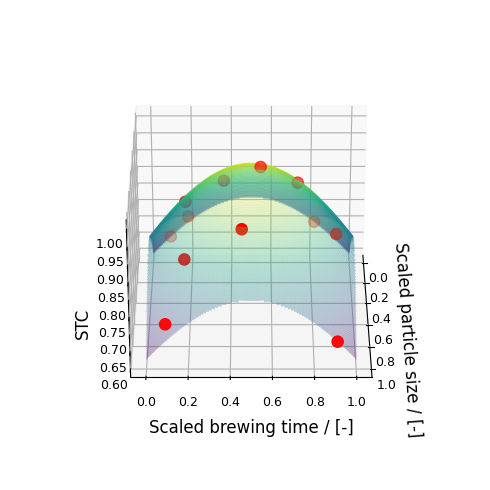

In [7]:
# Plot the ground truth function with our sample data
figname = 'Figure_2a'
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(projection='3d')
ax.contour(X, T, STC, 100, alpha=0.3)
ax.scatter(x, t, STC_samples, s=65, c='r')
ax.set_xlabel('Scaled particle size / [-]', fontsize=fontsize_text, labelpad=10)
ax.set_ylabel('Scaled brewing time / [-]', fontsize=fontsize_text, labelpad=10)
ax.set_zlabel('STC', fontsize=fontsize_text, rotation=90, labelpad=10)
ax.xaxis.set_tick_params(labelsize=fontsize_ticks)
ax.yaxis.set_tick_params(labelsize=fontsize_ticks)
ax.zaxis.set_tick_params(labelsize=fontsize_ticks)
ax.set_box_aspect(aspect=None, zoom=0.78)
plt.tight_layout()

# Make a video
if makevideo:
    # Save figure normally
    # plt.savefig(f'./{figname}.png', dpi=DPI)
    # Rotate figure and save frames
    for angle in list(np.linspace(0,360,int(360/video_angle_veocity))):
        ax.view_init(30, angle)
        # plt.draw() # Only needed in non-interactive mode (.py file)
        # plt.pause(.001) # Only needed in non-interactive mode (.py file)
        plt.savefig(f'./{figname}_{angle}.png', dpi=DPI)
    frames = []
    import imageio
    for angle in list(np.linspace(0,360,int(360/video_angle_veocity))):
        image = imageio.v2.imread(f'./{figname}_{angle}.png')
        frames.append(image)
    imageio.mimsave(f'.{figname}_gif.gif', # output gif
                    frames,          # array of input frames
                    fps = 5)         # optional: frames per second
    print('GIF saved!')
else:
    plt.savefig(f'./{figname}.png', dpi=DPI)
    plt.show()

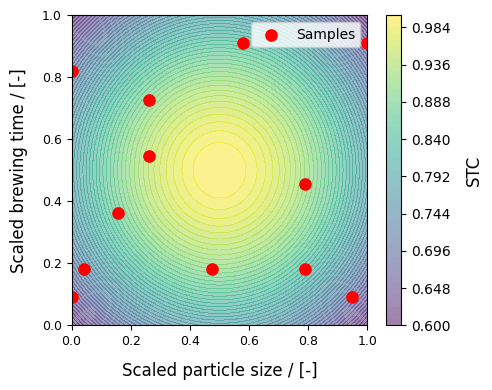

In [8]:
figname = 'Figure_2b'
fig = plt.figure()
ax = fig.gca()
CM=ax.contourf(X, T, STC, 100, alpha=0.5, levels=50, linestyles='solid')
cbar = fig.colorbar(CM)
cbar.ax.set_ylabel('STC', fontsize=fontsize_text, rotation=90, labelpad=10)
ax.scatter(x, t, s=65, c='r', label='Samples')
ax.set_xlabel('Scaled particle size / [-]', fontsize=fontsize_text, labelpad=10)
ax.set_ylabel('Scaled brewing time / [-]', fontsize=fontsize_text, labelpad=10)
ax.xaxis.set_tick_params(labelsize=fontsize_ticks)
ax.yaxis.set_tick_params(labelsize=fontsize_ticks)
ax.legend()
plt.tight_layout()
plt.savefig(f'./{figname}.png', dpi=DPI)

In [9]:
inputs = np.array([x, t]).T
outputs = np.array(STC_samples)
print(f'[+] Shape of inputs: {inputs.shape}')
print(f'[+] Shape of outputs: {outputs.shape}')

[+] Shape of inputs: (12, 2)
[+] Shape of outputs: (12,)


In [10]:
# Import the package
from pysr import PySRRegressor

# Instantiate the regressor
model = PySRRegressor(  niterations=100, population_size=150,
                        binary_operators=["*", "-"], unary_operators=["square", "exp"],
                        loss="f(x, y) = (x - y)^2", # Use a custom loss function
                        complexity_of_operators = {"square": 1, "exp": 1}, # Set the complexity of the operators
                        complexity_of_constants=0.5, # Set the complexity of the constants
                        complexity_of_variables=1, # Set the complexity of the variables
                        maxsize=12, # Allow greater complexity
                        maxdepth=6) # Avoid deep nesting

In [11]:
model.fit(inputs, outputs)

Compiling Julia backend...


/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1281: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:240: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(


PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                                 x1   
	1        3.041610e+00                                   exp(-0.21757866)   
	2        2.111941e-03                 (0.79453814 - (-0.021860028 * x1))   
	3        1.749250e+00              (0.9327944 - square(0.47921166 - x0))   
	4        2.741652e-02         (1.9463001 - exp(square(0.48114237 - x0)))   
	5        2.267900e-01  (0.90182495 - square(square(x0 - 0.48798713) *...   
	6        4.392597e-07  (0.90182805 - square(square(x0 - 0.48798332) *...   
	7  >>>>  1.890328e+01  exp((-3.1441355e-6 - square(x0 - 0.499998)) - ...   
	
	           loss  complexity  
	0  2.226494e-01           1  
	1  1.063328e-02           2  
	2  1.058846e-02           4  
	3  1.841378e-03           5  
	4  1.791579e-03           6  
	5  1.138279e-03           8  
	6  1.138279e-03           9  
	7  7.025195e-12          10  
]

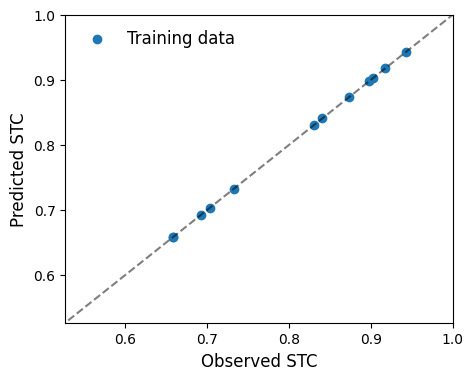

In [12]:
figname = 'Figure_3'
plt.figure()
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.scatter(outputs, model.predict(inputs), label='Training data')
plt.xlabel('Observed STC', fontsize=fontsize_text)
plt.ylabel('Predicted STC', fontsize=fontsize_text)
plt.xlim([np.min(outputs)*0.8, 1])
plt.ylim([np.min(outputs)*0.8, 1])
plt.legend(fontsize=12, frameon=False)
plt.savefig(f'./{figname}.png', dpi=DPI)
plt.show()

In [13]:
from sklearn.metrics import r2_score
r2 = r2_score(outputs, model.predict(inputs))
print(f'[+] Best identified model (LaTeX): {model.latex()}')
print(f'[+] R2 score: {r2}')

[+] Best identified model (LaTeX): 1.00 e^{- \left(x_{0} - 0.500\right)^{2} - \left(x_{1} - 0.500\right)^{2}}
[+] R2 score: 0.999999999337433


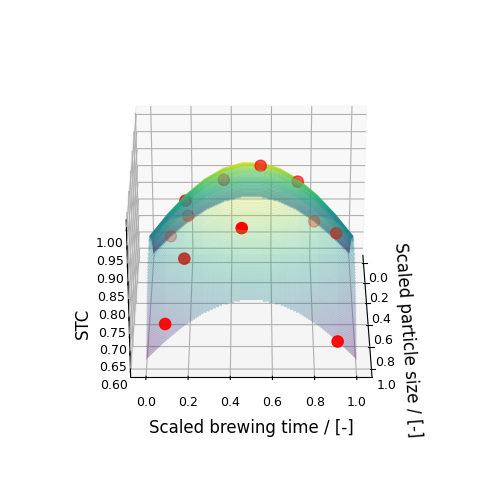

In [14]:
# Get a meshgrid for the samples (smaller than above)
X, T = np.meshgrid(np.linspace(xbounds[0], xbounds[1], len(x)), np.linspace(tbounds[0], tbounds[1], len(t)))
STCpred = np.zeros([len(x), len(t)])

# Extract each
for i in range(len(x)):
    for j in range(len(t)):
        datapoint = np.array([X[i,j], T[i,j]]).reshape(1,-1)
        STCpred[i,j] = model.predict(X=datapoint)[0]

# Plot
figname = 'Figure_4'
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(projection='3d')
ax.contour(X, T, STCpred, 100, alpha=0.3)
ax.scatter(x, t, STC_samples, s=65, c='r')
ax.set_xlabel('Scaled particle size / [-]', fontsize=fontsize_text, labelpad=10)
ax.set_ylabel('Scaled brewing time / [-]', fontsize=fontsize_text, labelpad=10)
ax.set_zlabel('STC', fontsize=fontsize_text, rotation=90, labelpad=10)
ax.xaxis.set_tick_params(labelsize=fontsize_ticks)
ax.yaxis.set_tick_params(labelsize=fontsize_ticks)
ax.zaxis.set_tick_params(labelsize=fontsize_ticks)
ax.set_box_aspect(aspect=None, zoom=0.78)
plt.tight_layout()

# Make a video
if makevideo:
    # Save figure normally
    plt.savefig(f'./{figname}.png', dpi=DPI)
    # Rotate figure and save frames
    for angle in list(np.linspace(0,360,int(360/video_angle_veocity))):
        ax.view_init(30, angle)
        # plt.draw() # Only needed in non-interactive mode (.py file)
        # plt.pause(.001) # Only needed in non-interactive mode (.py file)
        plt.savefig(f'./{figname}_{angle}.png', dpi=DPI)
    frames = []
    import imageio
    for angle in list(np.linspace(0,360,int(360/video_angle_veocity))):
        image = imageio.v2.imread(f'./{figname}_{angle}.png')
        frames.append(image)
    imageio.mimsave(f'./{figname}_gif.gif', # output gif
                    frames,          # array of input frames
                    fps = 5)         # optional: frames per second
else:
    plt.savefig(f'./{figname}.png', dpi=DPI)
    plt.show()

# Square Ising Model

Using Symbolic Regression in PySR package by Miles Cranmer to explore Ising model.

- The original PySR paper is: https://arxiv.org/pdf/2305.01582.pdf
- The PySR GitHub repository is: https://github.com/MilesCranmer/PySR
- The excellent docs for PySR are: https://astroautomata.com/PySR/

- The Ising model is by Rama Vasudevan, vasudevanrk@ornl.gov
- This model has been used in several of our publications, including https://pubs.aip.org/aip/jap/article/128/16/164304/568362/Exploration-of-lattice-Hamiltonians-for-functional

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand

from tqdm import tqdm
from typing import Union, Dict, Callable

import math
import time

In [16]:
# @title Ising model code
class IsingSim():

  """This class performs Ising model simulations on a 2D grid. Interaction parameters are given by a matrix at each lattice site.
  Field dependence is not supported at this time but will be in due course. The simulator outputs configurations after equlibrium
  as well as the trajectories, if specifically requested.
  Inputs:
    - N : (integer) - Size of lattice will be N^2. Only 2D square lattice is supported at this stage.
    - J_mat: (numpy matrix of shape(5,5)) - entries being floats for interaction parameters. Self-interaction (middle element of matrix)=0.
    - T: (float) - Reduced temperature for simulation
    - save_trajectories: (Boolean) - whether to save trajectories, or only final state. Default False.
    - eqSteps: (integer) number of Monte-Carlo steps for equlibration before simulation starts. Default 750. AKA 'burn-in'.
    - mcSteps: (integer) number of Monte-Carlo for simulation. Default 750.
  Outputs: Several outputs are available, including trajectories (if called), configurations (i.e., the 2D states) and configurations histograms.
  These can be obtained by calling methods self.configurations(), self.histograms() and self.trajectories()"""

  def __init__(self, N = 40, J_mat = None, T = 2.7, save_trajectories = False,
               eqSteps = 750, mcSteps = 750):
    self.N = N

    #If no J matrix is provided we default to isotropic J interaction with NN with value 0.5
    if np.array(J_mat).all() == None:
      J_mat = np.zeros((5,5))
      J_mat[1,2] = J_mat[2,1] = J_mat[2,3] = J_mat[3,2] = 0.5 #Defaulting to 0.5 for NN, all others zeroed out.

    self.J_mat = J_mat

    self.save_trajectories = save_trajectories
    self.eqSteps = eqSteps
    self.mcSteps = mcSteps
    self.config = self.initialState(random = False)
    self.T = T

  def initialState(self, random = False):
    ''' Generates a lattice with spin configurations drawn randomly [-1 or 1] if random=True
    Else, the lattice is generated with all sites = 1 '''

    if random==True: state = 2*np.random.randint(2, size=(self.N,self.N))-1
    else: state = np.ones([self.N,self.N])

    return state

  def mcmove(self, config):
    '''Monte Carlo move using Metropolis algorithm '''

    M = 5 #neighborhood size (M^2). Do not change!
    beta = 1.0/self.T

    for i in range(self.N):
      for j in range(self.N):
        J_mat = self.J_mat
        cost = 0.0
        s =  np.copy(config[i, j])

        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            cost += 2 * J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

        if cost < 0:
          s *= -1
        elif rand() < np.exp(-cost*beta):
          s *= -1
        config[i, j] = s
    return config


  def calcEnergy(self, config):
    '''Returns the energy of the current configuration'''
    M = 5
    energy = 0.0
    for i in range(len(config)):
      for j in range(len(config)):
        J_mat = self.J_mat #otherwise, no

        s = config[i,j]
        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            energy += -J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

    return energy/4.0


  def calcMag(self, config):
    '''Magnetization of a given configuration'''
    return np.sum(config)

  def calcAbsMag(self, config):
    ''' Absolute Magnetization of a given configuration'''
    return (np.abs(np.sum(config)))*1.0

  def performIsingSim(self):

    E1, M1, E2, M2 = 0.0,0.0,0.0,0.0    #These are all the average properties of all MC steps used
    E_traj, M_traj = np.zeros(self.mcSteps), np.zeros(self.mcSteps)

    config = np.copy(self.config)
    T = self.T
    if self.save_trajectories: config_mat = np.zeros([self.mcSteps,self.N,self.N])   #Saving all the configurations


    print('\n---Performing Equlibration---\n')
    for i in tqdm(range(self.eqSteps)):
        config = self.mcmove(config)

    print('\n---Finished...\n----Performing MC Moves----\n')
    for j in tqdm(range(self.mcSteps)):
        config = self.mcmove(config)
        Ene, Mag = self.calcEnergy(config), self.calcAbsMag(config)
        E_traj[j] = self.calcEnergy(config)/(self.N*self.N)
        M_traj[j] = self.calcAbsMag(config)/(self.N*self.N)

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag * Mag
        E2 = E2 + Ene * Ene

        if self.save_trajectories: config_mat[j] = config

    print('Completed. Saving')
    Energy = E1 / (self.mcSteps * self.N * self.N)
    Magnetization = M1 / (self.mcSteps * self.N * self.N)
    n1, n2  = 1.0/(self.mcSteps*self.N*self.N), 1.0/(self.mcSteps*self.mcSteps*self.N*self.N)
    iT = 1.0/self.T
    iT2 = iT*iT
    SpecificHeat = (n1*E2 - n2*E1*E1)*iT2
    Susceptibility = (n1*M2 - n2*M1*M1)*iT
    # SpecificHeat = (E2 / self.mcSteps - E1 * E1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T * self.T)
    # Susceptibility = (M2 / self.mcSteps - M1 * M1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T)

    self.config = config


    if self.save_trajectories:
      results_dict = {'config': config_mat, 'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility, 'E_traj': E_traj,
      'M_traj': M_traj,
      }
    else:
      results_dict = {'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility,
      'E_traj': E_traj, 'M_traj': M_traj,}

    self.results = results_dict

    return 'Completed simulation'

## Evaluation

In [17]:
lb = 0
ub = 3
N_total = 201

#bounds = np.array((lb, ub), dtype=float)
xs = np.linspace(lb, ub, N_total)

Full grid evaluation for 20x20 1D Ising model - Square Model

Recommended parameters:
- 20x20 field
- 500 steps for equilibration
- 500 steps for computation

However, if you are impatient, run (10x10, 50, 50)

Evaluation 1 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 235.55it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.28it/s]


Completed. Saving
Time (s) to complete simulation 1: 0.8110299110412598


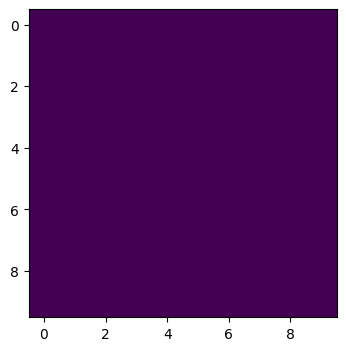

Evaluation 2 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 216.22it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.62it/s]


Completed. Saving
Time (s) to complete simulation 2: 0.8039720058441162


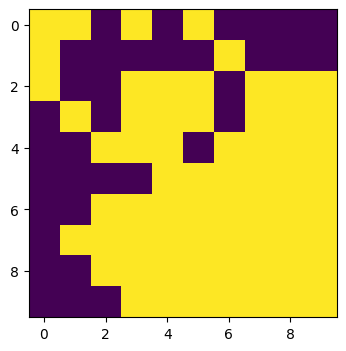

Evaluation 3 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 228.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.14it/s]


Completed. Saving
Time (s) to complete simulation 3: 0.7890033721923828


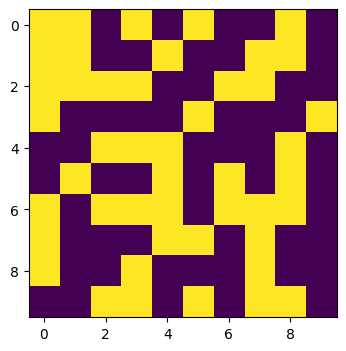

Evaluation 4 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 225.17it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.18it/s]


Completed. Saving
Time (s) to complete simulation 4: 0.812164306640625


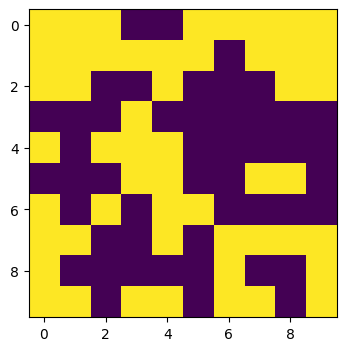

Evaluation 5 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 226.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.54it/s]


Completed. Saving
Time (s) to complete simulation 5: 0.814629316329956


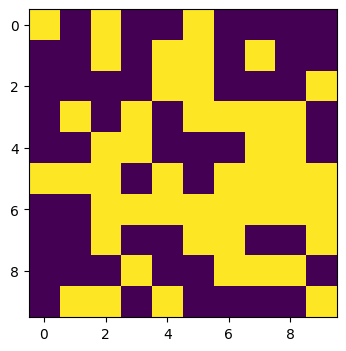

Evaluation 6 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 230.36it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.72it/s]


Completed. Saving
Time (s) to complete simulation 6: 0.8109149932861328


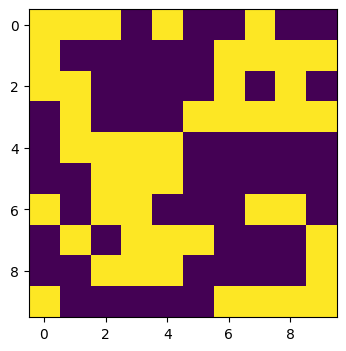

Evaluation 7 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 231.78it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.46it/s]


Completed. Saving
Time (s) to complete simulation 7: 0.8230392932891846


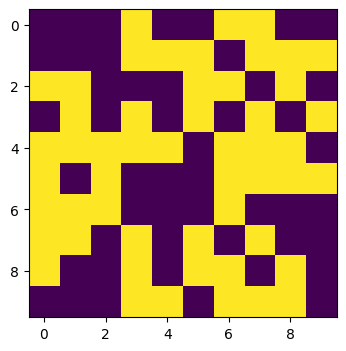

Evaluation 8 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 230.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.01it/s]


Completed. Saving
Time (s) to complete simulation 8: 0.8097801208496094


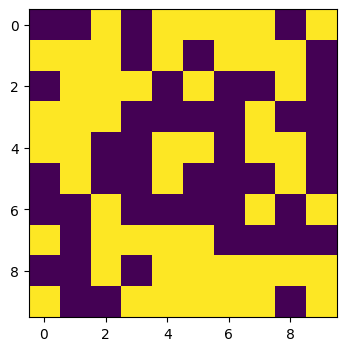

Evaluation 9 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.15it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.89it/s]


Completed. Saving
Time (s) to complete simulation 9: 1.2435593605041504


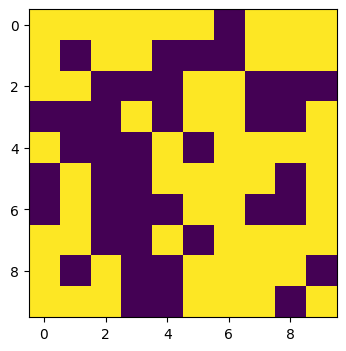

Evaluation 10 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 124.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.80it/s]


Completed. Saving
Time (s) to complete simulation 10: 1.4288034439086914


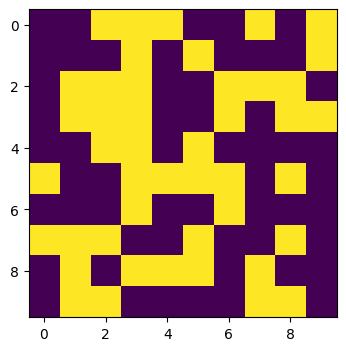

Evaluation 11 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 256.88it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.96it/s]


Completed. Saving
Time (s) to complete simulation 11: 0.7658486366271973


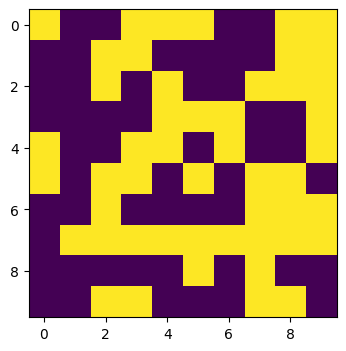

Evaluation 12 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 255.72it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.13it/s]


Completed. Saving
Time (s) to complete simulation 12: 0.757239818572998


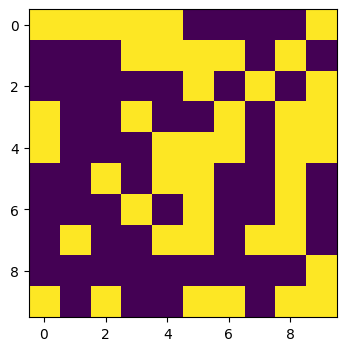

Evaluation 13 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 250.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 94.81it/s]


Completed. Saving
Time (s) to complete simulation 13: 0.7411673069000244


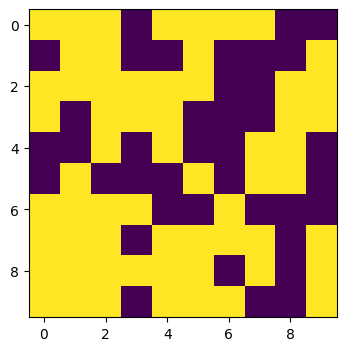

Evaluation 14 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 255.27it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.35it/s]


Completed. Saving
Time (s) to complete simulation 14: 0.746260404586792


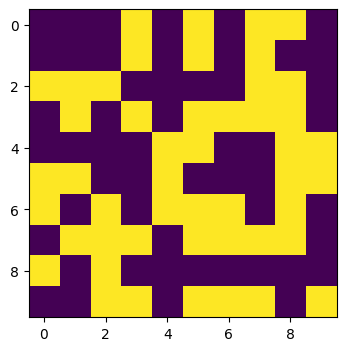

Evaluation 15 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 242.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.38it/s]


Completed. Saving
Time (s) to complete simulation 15: 0.7683432102203369


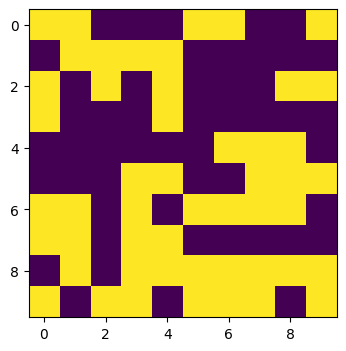

Evaluation 16 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 240.52it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 95.01it/s]


Completed. Saving
Time (s) to complete simulation 16: 0.7535316944122314


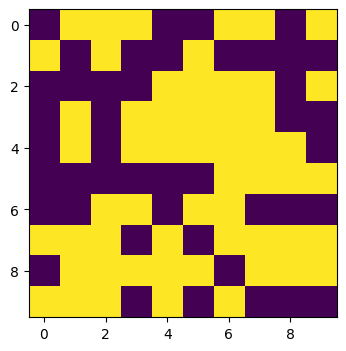

Evaluation 17 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 244.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.57it/s]


Completed. Saving
Time (s) to complete simulation 17: 0.7557287216186523


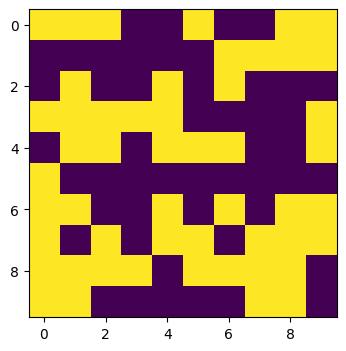

Evaluation 18 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 231.52it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.44it/s]


Completed. Saving
Time (s) to complete simulation 18: 0.7552509307861328


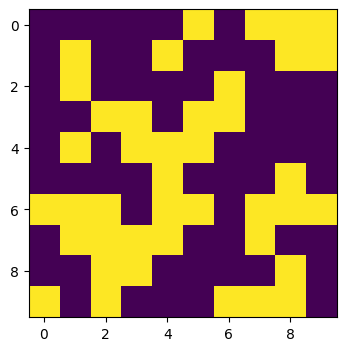

Evaluation 19 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 221.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 95.66it/s]


Completed. Saving
Time (s) to complete simulation 19: 0.7659475803375244


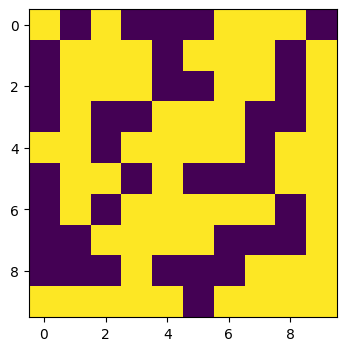

Evaluation 20 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.48it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 96.75it/s]


Completed. Saving
Time (s) to complete simulation 20: 0.7822613716125488


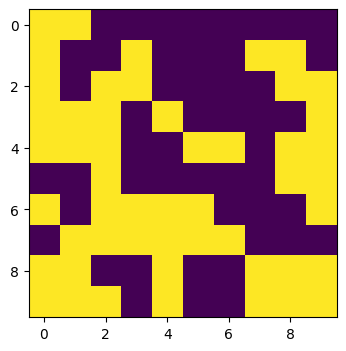

Evaluation 21 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.31it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 64.07it/s]


Completed. Saving
Time (s) to complete simulation 21: 1.0317249298095703


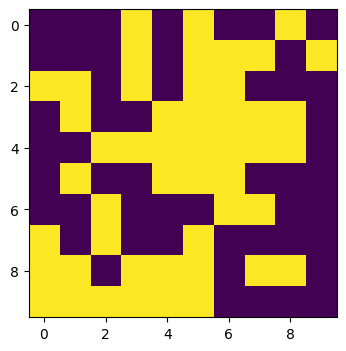

Evaluation 22 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 131.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.28it/s]


Completed. Saving
Time (s) to complete simulation 22: 1.3709957599639893


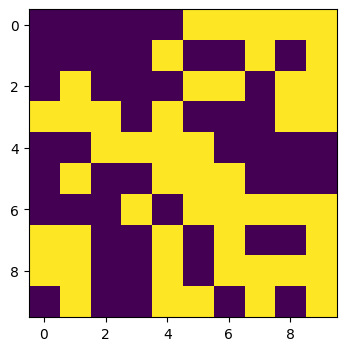

Evaluation 23 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 136.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.01it/s]


Completed. Saving
Time (s) to complete simulation 23: 0.9523131847381592


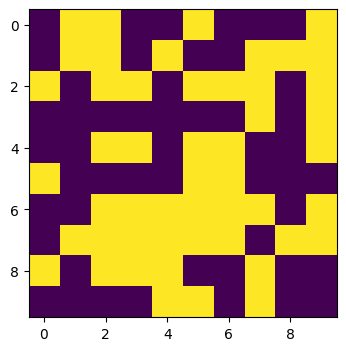

Evaluation 24 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 231.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.37it/s]


Completed. Saving
Time (s) to complete simulation 24: 0.7749841213226318


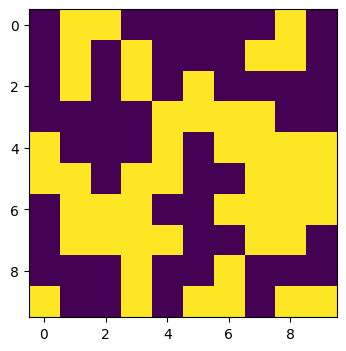

Evaluation 25 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 231.38it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.50it/s]


Completed. Saving
Time (s) to complete simulation 25: 0.7872464656829834


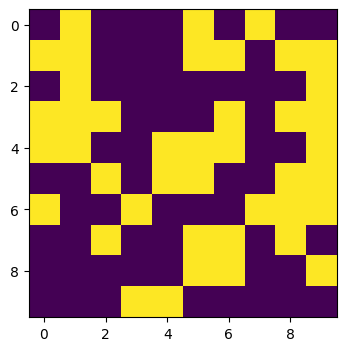

Evaluation 26 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 238.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.80it/s]


Completed. Saving
Time (s) to complete simulation 26: 0.7814681529998779


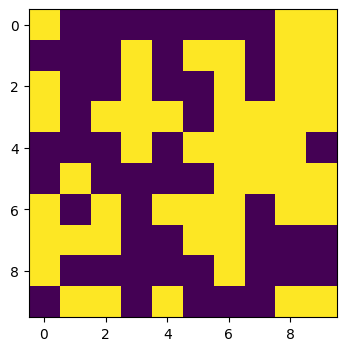

Evaluation 27 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.35it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.13it/s]


Completed. Saving
Time (s) to complete simulation 27: 0.7929580211639404


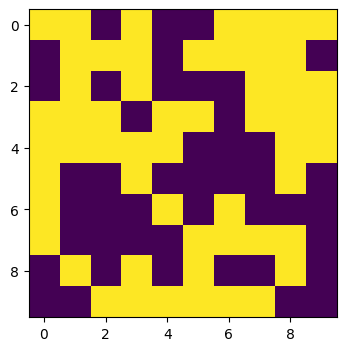

Evaluation 28 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 234.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.00it/s]


Completed. Saving
Time (s) to complete simulation 28: 0.7853069305419922


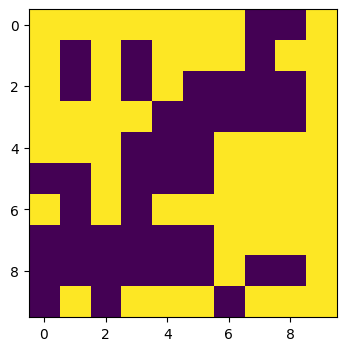

Evaluation 29 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 229.73it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.13it/s]


Completed. Saving
Time (s) to complete simulation 29: 0.7697207927703857


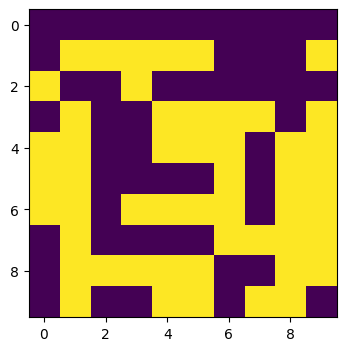

Evaluation 30 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 235.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.86it/s]


Completed. Saving
Time (s) to complete simulation 30: 0.7998695373535156


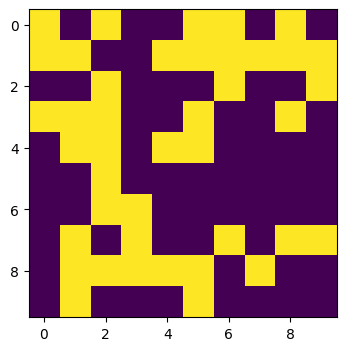

Evaluation 31 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 226.48it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.01it/s]


Completed. Saving
Time (s) to complete simulation 31: 0.8062620162963867


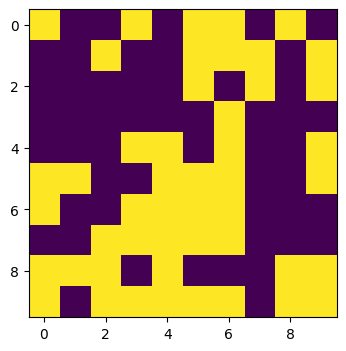

Evaluation 32 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 228.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.61it/s]


Completed. Saving
Time (s) to complete simulation 32: 0.7808120250701904


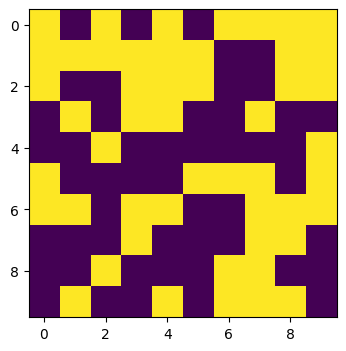

Evaluation 33 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 244.08it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 53.44it/s]


Completed. Saving
Time (s) to complete simulation 33: 1.1587395668029785


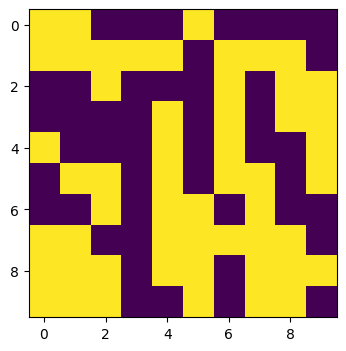

Evaluation 34 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 131.55it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.05it/s]


Completed. Saving
Time (s) to complete simulation 34: 1.3966002464294434


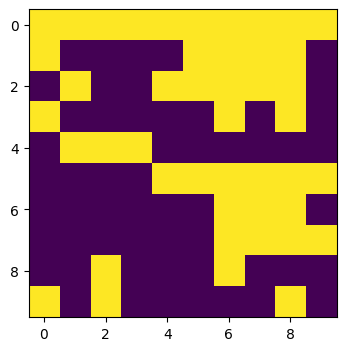

Evaluation 35 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 144.79it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.73it/s]


Completed. Saving
Time (s) to complete simulation 35: 0.9299015998840332


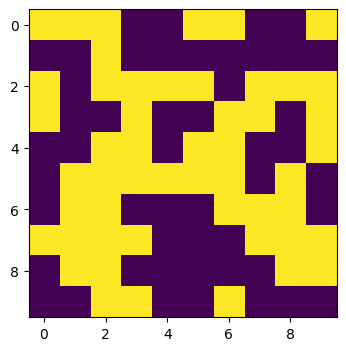

Evaluation 36 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 247.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.38it/s]


Completed. Saving
Time (s) to complete simulation 36: 0.7622530460357666


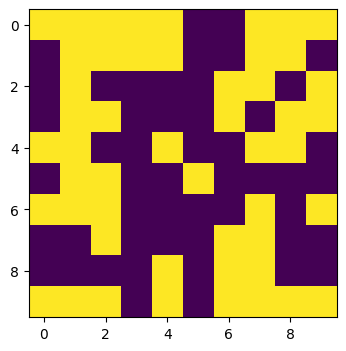

Evaluation 37 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 242.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.89it/s]


Completed. Saving
Time (s) to complete simulation 37: 0.7873435020446777


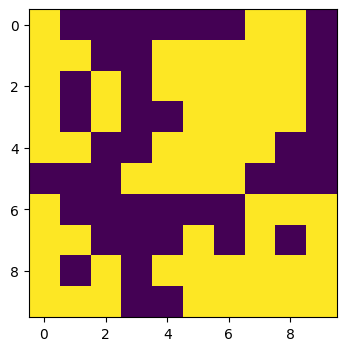

Evaluation 38 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 231.57it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.48it/s]


Completed. Saving
Time (s) to complete simulation 38: 0.7836639881134033


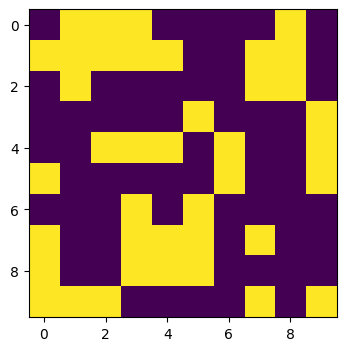

Evaluation 39 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 228.30it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.48it/s]


Completed. Saving
Time (s) to complete simulation 39: 0.8069779872894287


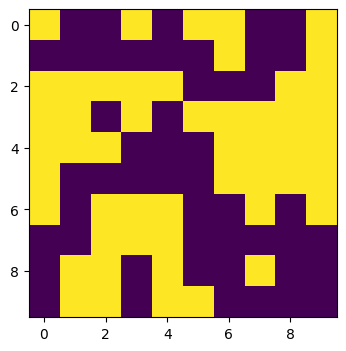

Evaluation 40 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.13it/s]


Completed. Saving
Time (s) to complete simulation 40: 0.7902758121490479


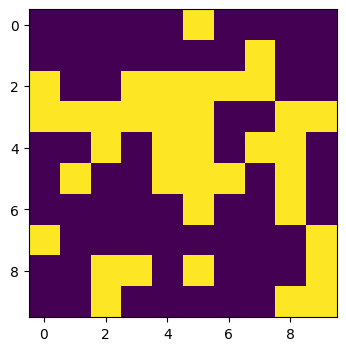

Evaluation 41 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 239.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.95it/s]


Completed. Saving
Time (s) to complete simulation 41: 0.8058934211730957


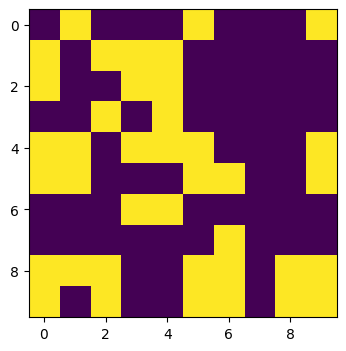

Evaluation 42 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 215.47it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.44it/s]


Completed. Saving
Time (s) to complete simulation 42: 0.813664436340332


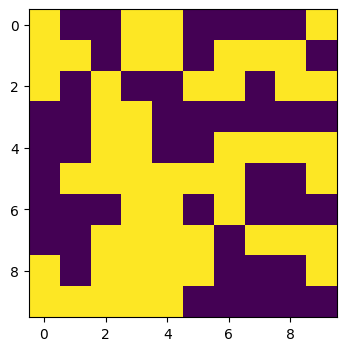

Evaluation 43 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 236.05it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.82it/s]


Completed. Saving
Time (s) to complete simulation 43: 0.7717251777648926


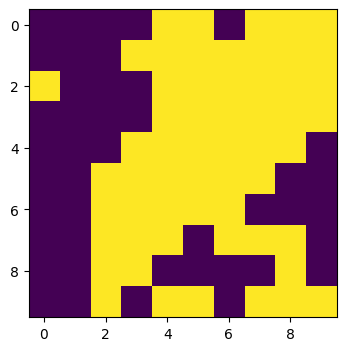

Evaluation 44 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 232.42it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.66it/s]


Completed. Saving
Time (s) to complete simulation 44: 0.7653055191040039


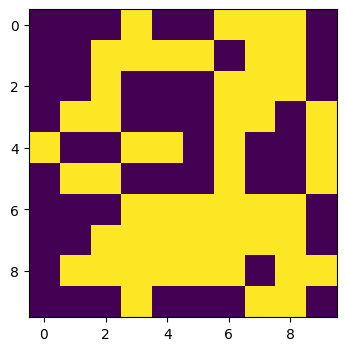

Evaluation 45 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 249.94it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 55.45it/s]


Completed. Saving
Time (s) to complete simulation 45: 1.1280121803283691


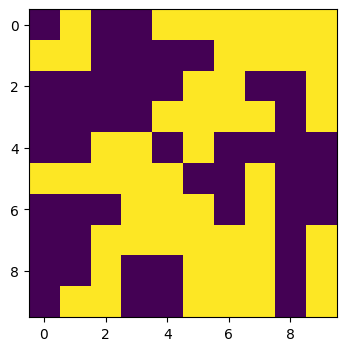

Evaluation 46 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 123.05it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.46it/s]


Completed. Saving
Time (s) to complete simulation 46: 1.4425737857818604


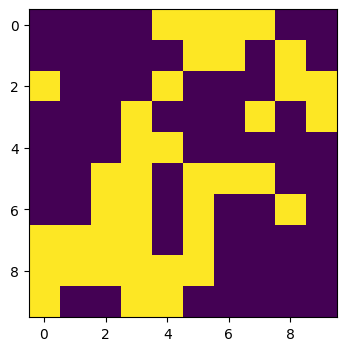

Evaluation 47 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 153.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.74it/s]


Completed. Saving
Time (s) to complete simulation 47: 0.9039154052734375


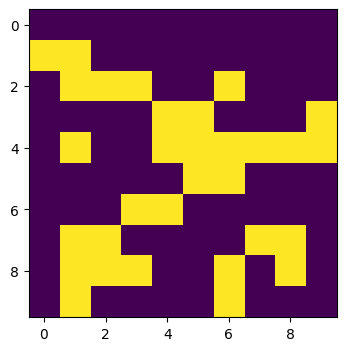

Evaluation 48 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 236.41it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.82it/s]


Completed. Saving
Time (s) to complete simulation 48: 0.7783098220825195


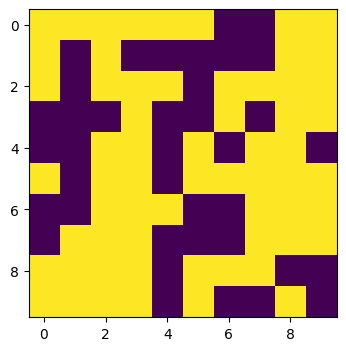

Evaluation 49 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 232.41it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.29it/s]


Completed. Saving
Time (s) to complete simulation 49: 0.7910196781158447


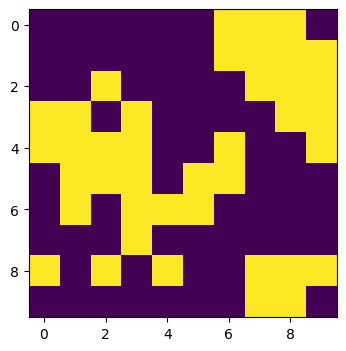

Evaluation 50 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 239.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.28it/s]


Completed. Saving
Time (s) to complete simulation 50: 0.7875776290893555


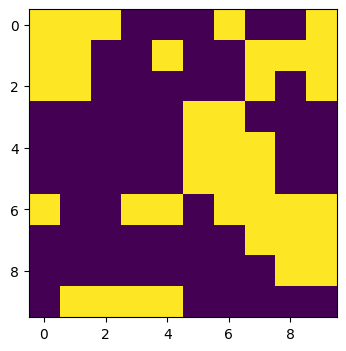

Evaluation 51 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 228.06it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.25it/s]


Completed. Saving
Time (s) to complete simulation 51: 0.7958722114562988


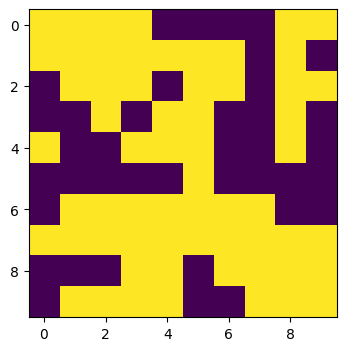

Evaluation 52 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 201.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.80it/s]


Completed. Saving
Time (s) to complete simulation 52: 0.8199765682220459


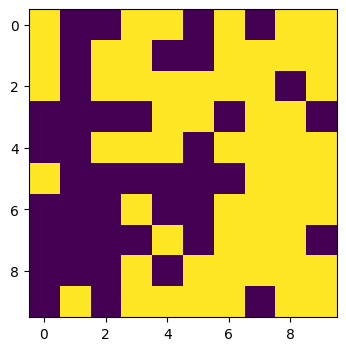

Evaluation 53 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.91it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.95it/s]


Completed. Saving
Time (s) to complete simulation 53: 0.8051891326904297


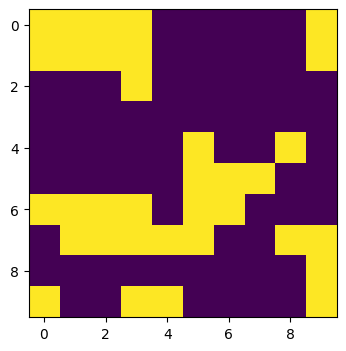

Evaluation 54 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 218.78it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.28it/s]


Completed. Saving
Time (s) to complete simulation 54: 0.8116116523742676


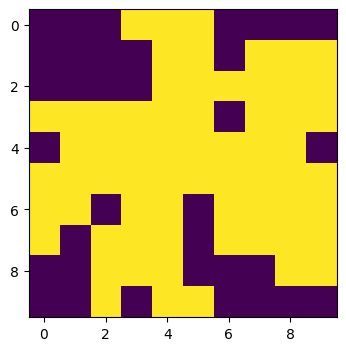

Evaluation 55 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 215.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.90it/s]


Completed. Saving
Time (s) to complete simulation 55: 0.797175407409668


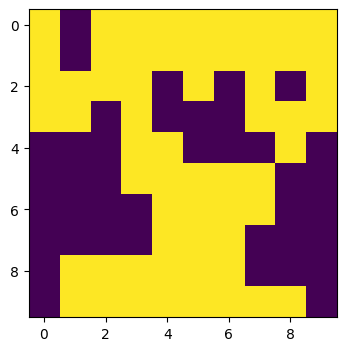

Evaluation 56 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.43it/s]


Completed. Saving
Time (s) to complete simulation 56: 0.8311951160430908


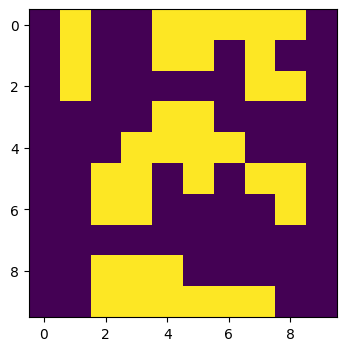

Evaluation 57 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 173.40it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.09it/s]


Completed. Saving
Time (s) to complete simulation 57: 1.3076953887939453


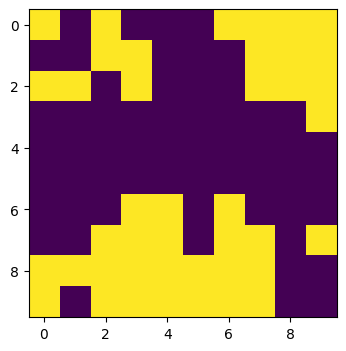

Evaluation 58 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 132.87it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.67it/s]


Completed. Saving
Time (s) to complete simulation 58: 1.3435614109039307


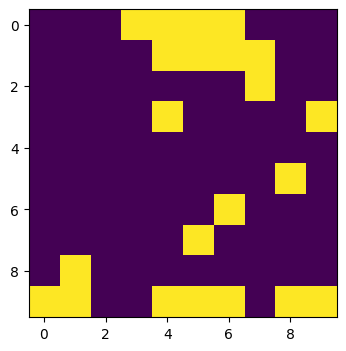

Evaluation 59 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.79it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.91it/s]


Completed. Saving
Time (s) to complete simulation 59: 0.8137316703796387


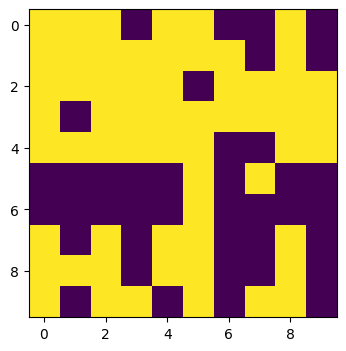

Evaluation 60 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 202.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.15it/s]


Completed. Saving
Time (s) to complete simulation 60: 0.8165073394775391


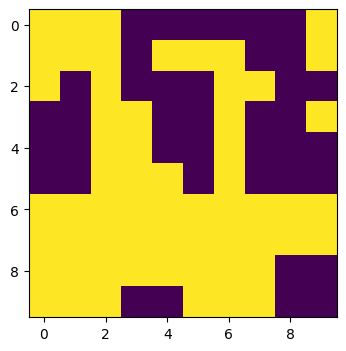

Evaluation 61 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.54it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.48it/s]


Completed. Saving
Time (s) to complete simulation 61: 0.8073532581329346


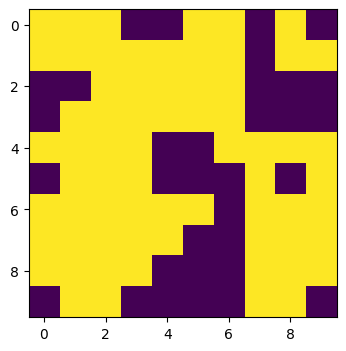

Evaluation 62 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.36it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.86it/s]


Completed. Saving
Time (s) to complete simulation 62: 0.8357038497924805


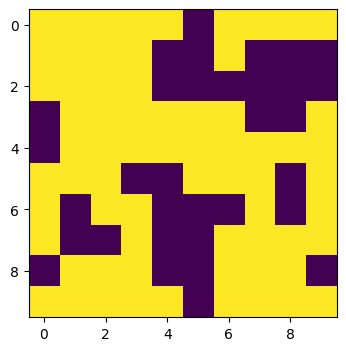

Evaluation 63 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.54it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.66it/s]


Completed. Saving
Time (s) to complete simulation 63: 0.843055248260498


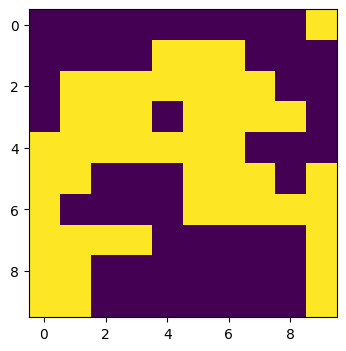

Evaluation 64 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.90it/s]


Completed. Saving
Time (s) to complete simulation 64: 0.8037006855010986


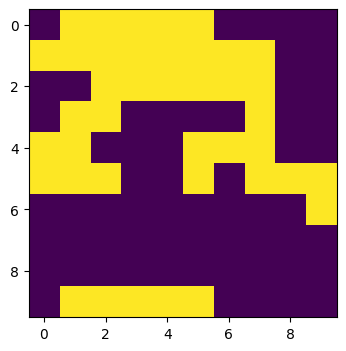

Evaluation 65 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.79it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.08it/s]


Completed. Saving
Time (s) to complete simulation 65: 0.8185064792633057


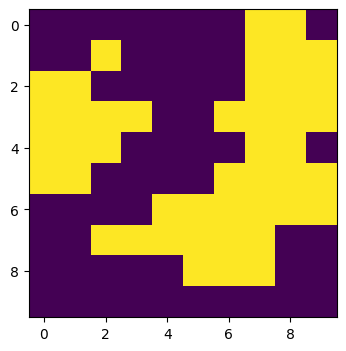

Evaluation 66 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 225.54it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.58it/s]


Completed. Saving
Time (s) to complete simulation 66: 0.8280572891235352


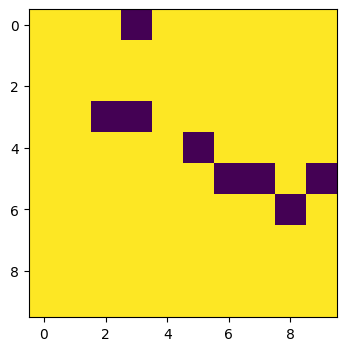

Evaluation 67 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 221.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.80it/s]


Completed. Saving
Time (s) to complete simulation 67: 0.8363280296325684


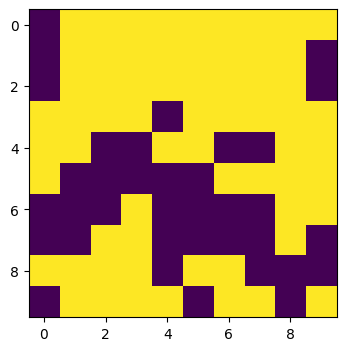

Evaluation 68 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.78it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.12it/s]


Completed. Saving
Time (s) to complete simulation 68: 0.8097271919250488


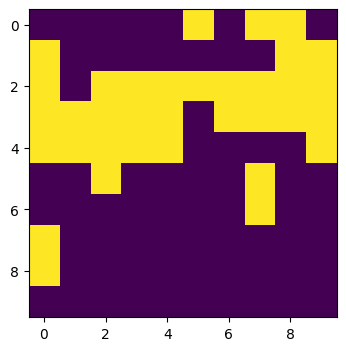

Evaluation 69 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 134.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.40it/s]


Completed. Saving
Time (s) to complete simulation 69: 1.3696198463439941


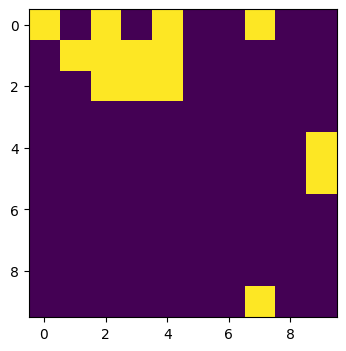

Evaluation 70 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 141.90it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.95it/s]


Completed. Saving
Time (s) to complete simulation 70: 1.3322875499725342


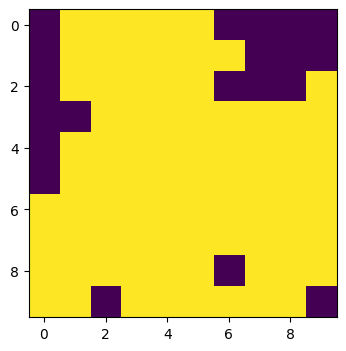

Evaluation 71 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 150.78it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.01it/s]


Completed. Saving
Time (s) to complete simulation 71: 0.9081485271453857


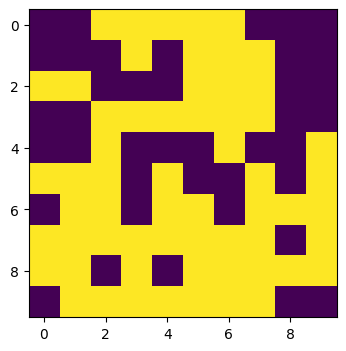

Evaluation 72 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.40it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 91.06it/s]


Completed. Saving
Time (s) to complete simulation 72: 0.8079829216003418


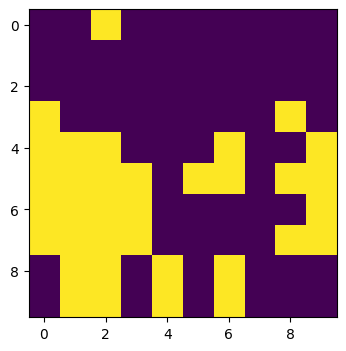

Evaluation 73 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.05it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.48it/s]


Completed. Saving
Time (s) to complete simulation 73: 0.8077793121337891


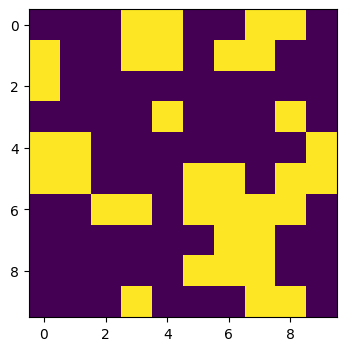

Evaluation 74 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.81it/s]


Completed. Saving
Time (s) to complete simulation 74: 0.8362784385681152


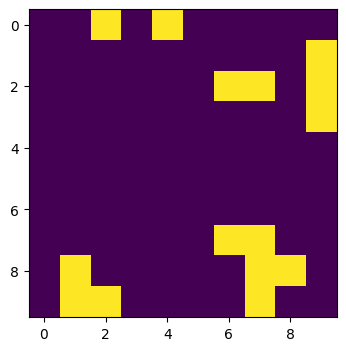

Evaluation 75 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.57it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.28it/s]


Completed. Saving
Time (s) to complete simulation 75: 0.8218963146209717


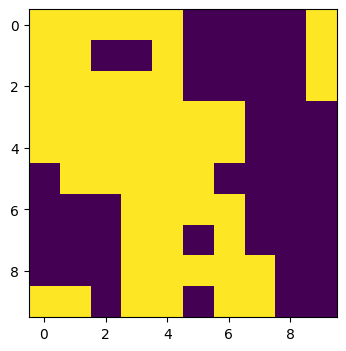

Evaluation 76 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.69it/s]


Completed. Saving
Time (s) to complete simulation 76: 0.8228802680969238


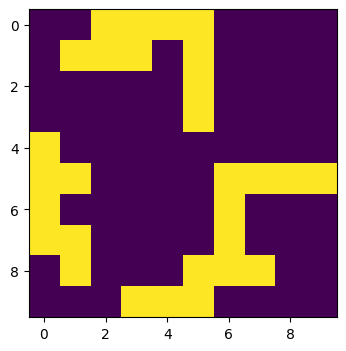

Evaluation 77 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.69it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.90it/s]


Completed. Saving
Time (s) to complete simulation 77: 0.8158864974975586


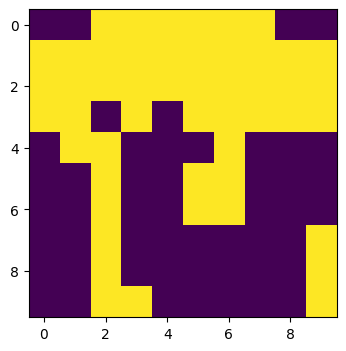

Evaluation 78 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.99it/s]


Completed. Saving
Time (s) to complete simulation 78: 0.82021164894104


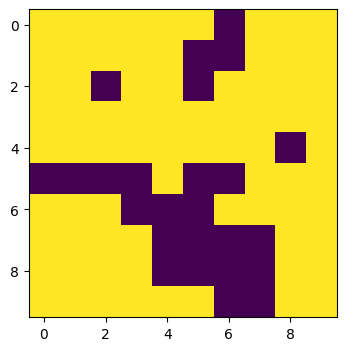

Evaluation 79 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.05it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.69it/s]


Completed. Saving
Time (s) to complete simulation 79: 0.802009105682373


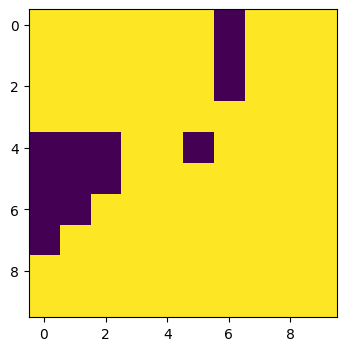

Evaluation 80 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 216.21it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.68it/s]


Completed. Saving
Time (s) to complete simulation 80: 0.823326826095581


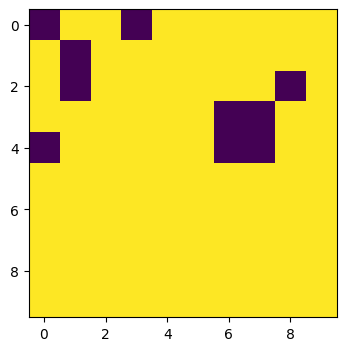

Evaluation 81 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 130.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.14it/s]


Completed. Saving
Time (s) to complete simulation 81: 1.4008636474609375


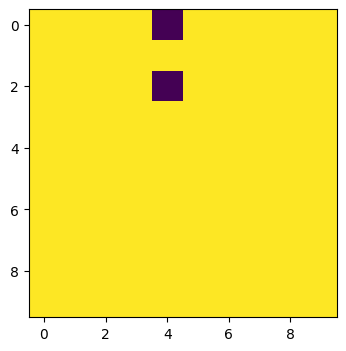

Evaluation 82 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 129.20it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.95it/s]


Completed. Saving
Time (s) to complete simulation 82: 1.3917396068572998


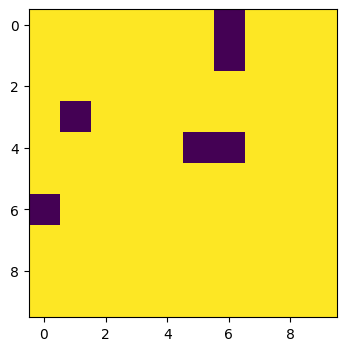

Evaluation 83 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.22it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.76it/s]


Completed. Saving
Time (s) to complete simulation 83: 0.8240342140197754


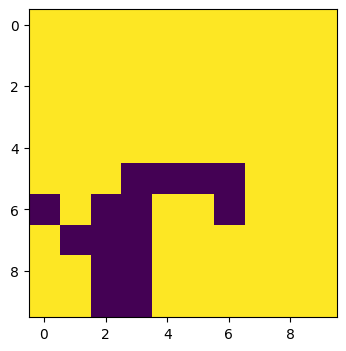

Evaluation 84 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.54it/s]


Completed. Saving
Time (s) to complete simulation 84: 0.8129148483276367


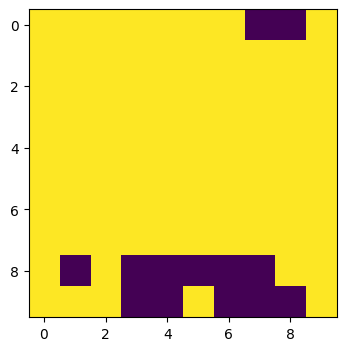

Evaluation 85 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.47it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.77it/s]


Completed. Saving
Time (s) to complete simulation 85: 0.8306422233581543


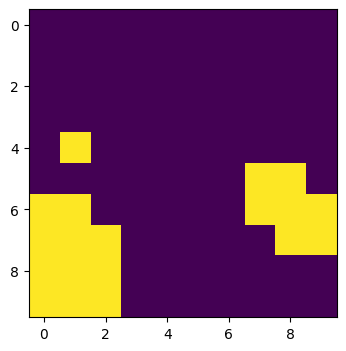

Evaluation 86 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.03it/s]


Completed. Saving
Time (s) to complete simulation 86: 0.8158581256866455


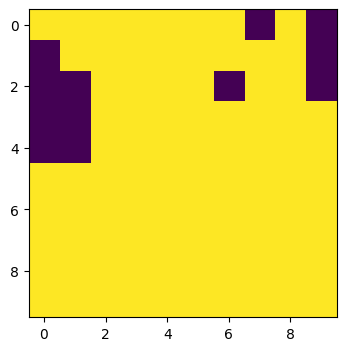

Evaluation 87 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.42it/s]


Completed. Saving
Time (s) to complete simulation 87: 0.8489980697631836


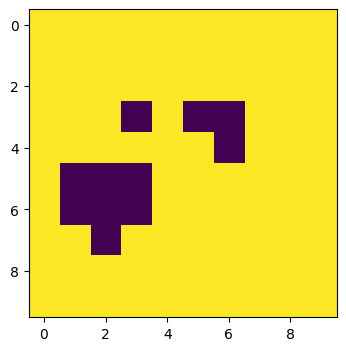

Evaluation 88 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.58it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.56it/s]


Completed. Saving
Time (s) to complete simulation 88: 0.8309149742126465


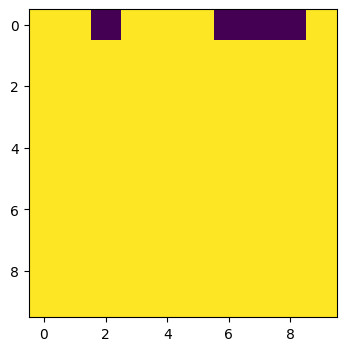

Evaluation 89 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.28it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.52it/s]


Completed. Saving
Time (s) to complete simulation 89: 0.8531408309936523


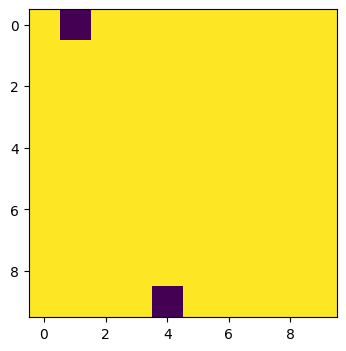

Evaluation 90 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.13it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.02it/s]


Completed. Saving
Time (s) to complete simulation 90: 0.831812858581543


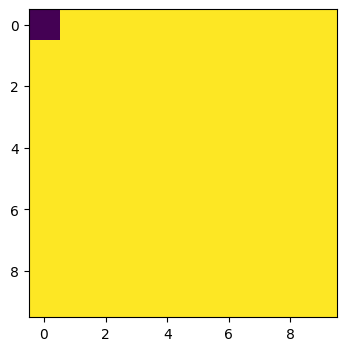

Evaluation 91 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.69it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.01it/s]


Completed. Saving
Time (s) to complete simulation 91: 0.8297417163848877


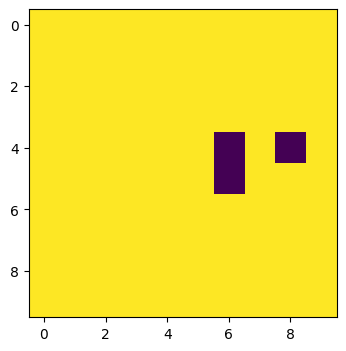

Evaluation 92 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 75.66it/s]


Completed. Saving
Time (s) to complete simulation 92: 0.9243998527526855


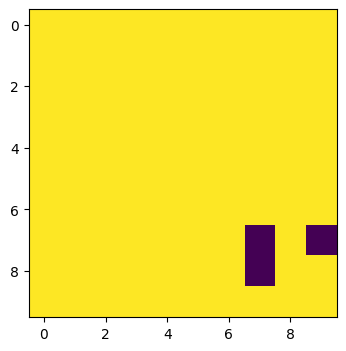

Evaluation 93 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 138.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.79it/s]


Completed. Saving
Time (s) to complete simulation 93: 1.4073822498321533


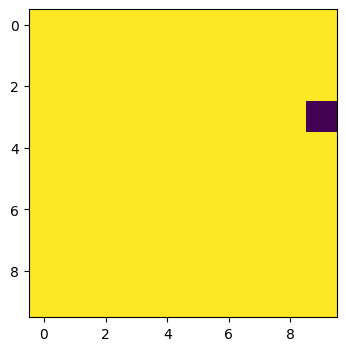

Evaluation 94 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 141.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 59.71it/s]


Completed. Saving
Time (s) to complete simulation 94: 1.205260992050171


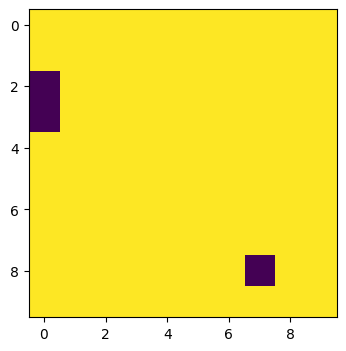

Evaluation 95 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.47it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.53it/s]


Completed. Saving
Time (s) to complete simulation 95: 0.8368279933929443


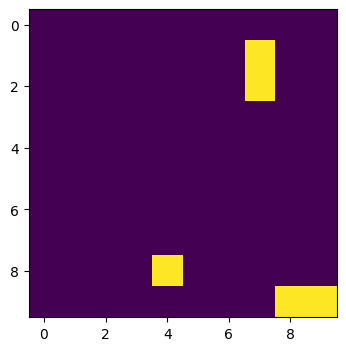

Evaluation 96 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.91it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.25it/s]


Completed. Saving
Time (s) to complete simulation 96: 0.834036111831665


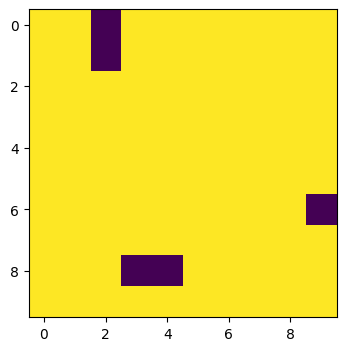

Evaluation 97 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.99it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.06it/s]


Completed. Saving
Time (s) to complete simulation 97: 0.8544957637786865


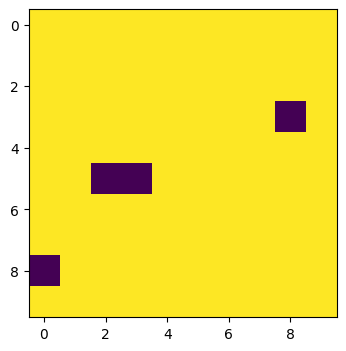

Evaluation 98 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.38it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.87it/s]


Completed. Saving
Time (s) to complete simulation 98: 0.8461155891418457


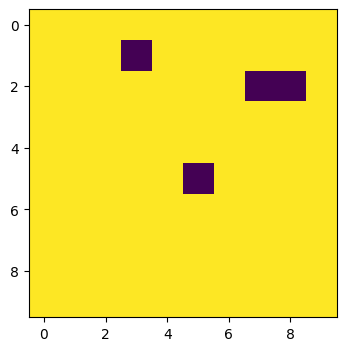

Evaluation 99 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.17it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.21it/s]


Completed. Saving
Time (s) to complete simulation 99: 0.8325958251953125


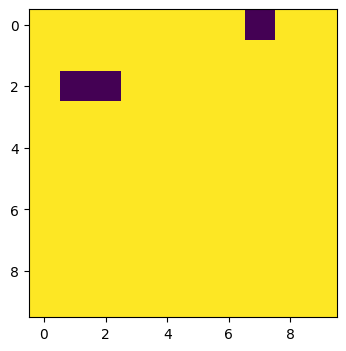

Evaluation 100 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 220.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.45it/s]


Completed. Saving
Time (s) to complete simulation 100: 0.833958625793457


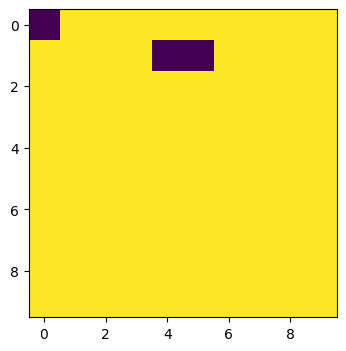

Evaluation 101 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.82it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.56it/s]


Completed. Saving
Time (s) to complete simulation 101: 0.8464648723602295


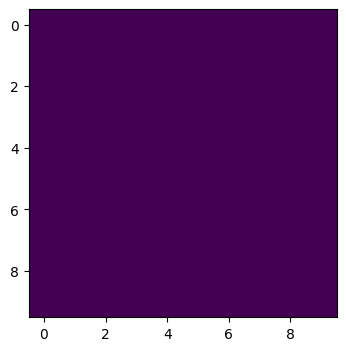

Evaluation 102 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.82it/s]


Completed. Saving
Time (s) to complete simulation 102: 0.836785078048706


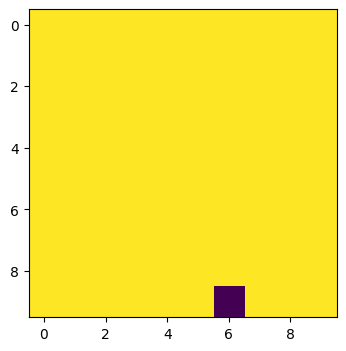

Evaluation 103 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.54it/s]


Completed. Saving
Time (s) to complete simulation 103: 0.8406744003295898


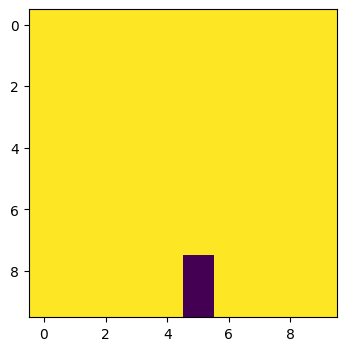

Evaluation 104 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.42it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.41it/s]


Completed. Saving
Time (s) to complete simulation 104: 1.131197214126587


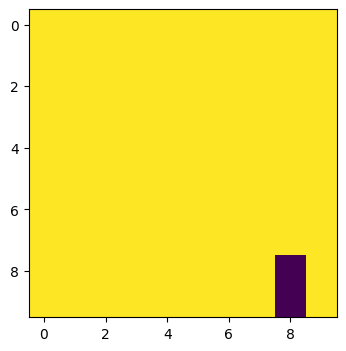

Evaluation 105 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 134.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.14it/s]


Completed. Saving
Time (s) to complete simulation 105: 1.3657116889953613


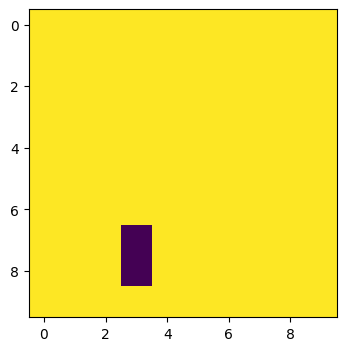

Evaluation 106 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 147.72it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 67.12it/s]


Completed. Saving
Time (s) to complete simulation 106: 1.1017413139343262


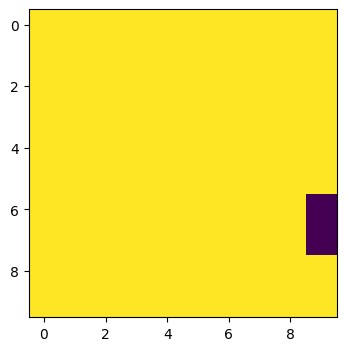

Evaluation 107 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 191.29it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.94it/s]


Completed. Saving
Time (s) to complete simulation 107: 0.8586077690124512


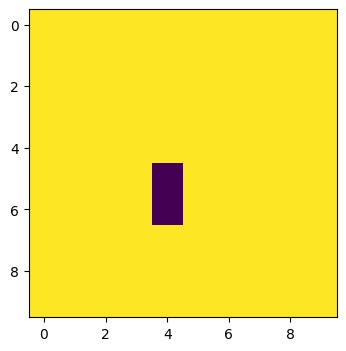

Evaluation 108 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.63it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.26it/s]


Completed. Saving
Time (s) to complete simulation 108: 0.8584721088409424


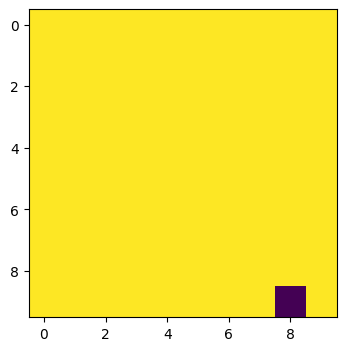

Evaluation 109 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.38it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.76it/s]


Completed. Saving
Time (s) to complete simulation 109: 0.8296520709991455


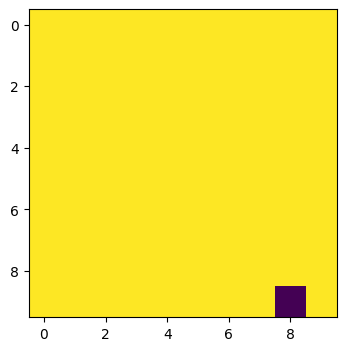

Evaluation 110 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.91it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.32it/s]


Completed. Saving
Time (s) to complete simulation 110: 0.8632111549377441


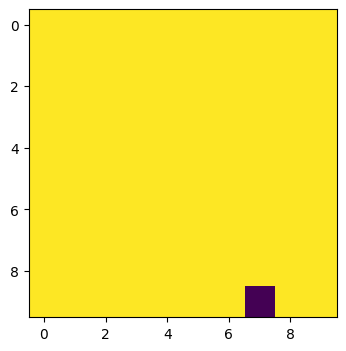

Evaluation 111 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 194.60it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.46it/s]


Completed. Saving
Time (s) to complete simulation 111: 0.8422801494598389


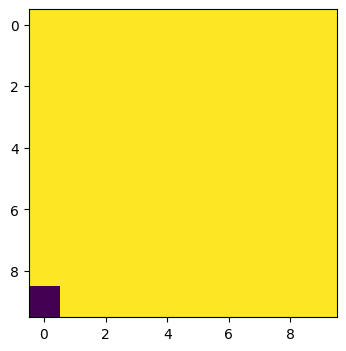

Evaluation 112 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.15it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.37it/s]


Completed. Saving
Time (s) to complete simulation 112: 0.8305494785308838


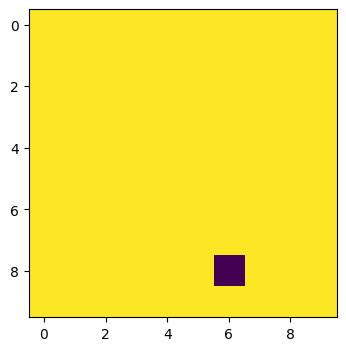

Evaluation 113 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.10it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.14it/s]


Completed. Saving
Time (s) to complete simulation 113: 0.8439614772796631


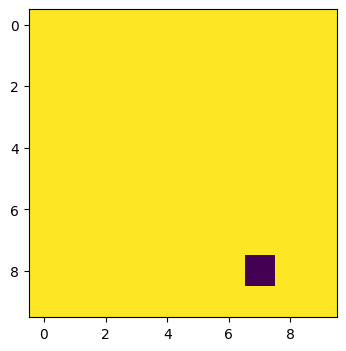

Evaluation 114 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 196.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.86it/s]


Completed. Saving
Time (s) to complete simulation 114: 0.8546903133392334


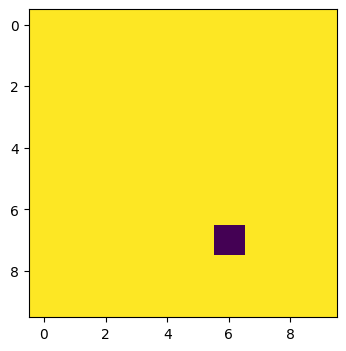

Evaluation 115 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 196.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.63it/s]


Completed. Saving
Time (s) to complete simulation 115: 0.8518311977386475


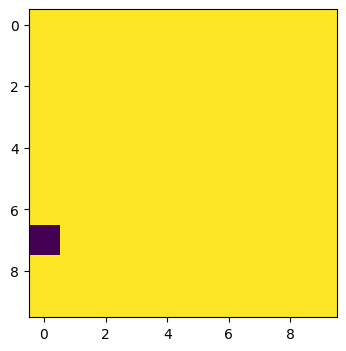

Evaluation 116 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 139.59it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.57it/s]


Completed. Saving
Time (s) to complete simulation 116: 1.3496263027191162


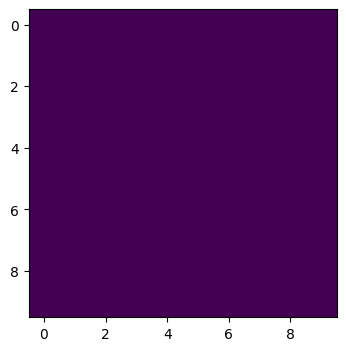

Evaluation 117 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 129.40it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.21it/s]


Completed. Saving
Time (s) to complete simulation 117: 1.3673064708709717


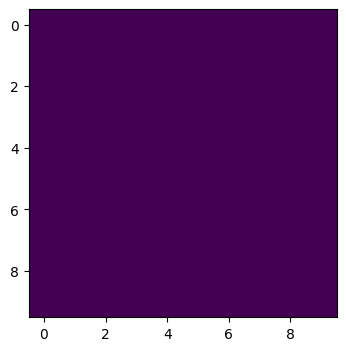

Evaluation 118 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.06it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.49it/s]


Completed. Saving
Time (s) to complete simulation 118: 0.8610501289367676


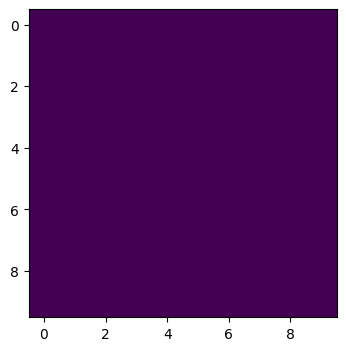

Evaluation 119 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.15it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.17it/s]


Completed. Saving
Time (s) to complete simulation 119: 0.850954532623291


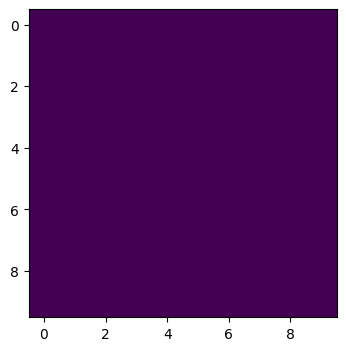

Evaluation 120 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.05it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.80it/s]


Completed. Saving
Time (s) to complete simulation 120: 0.869971752166748


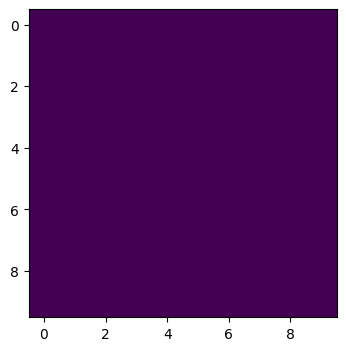

Evaluation 121 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.27it/s]


Completed. Saving
Time (s) to complete simulation 121: 0.8644731044769287


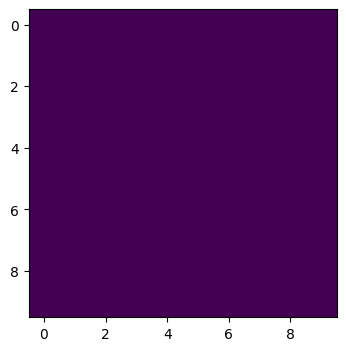

Evaluation 122 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.26it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.10it/s]


Completed. Saving
Time (s) to complete simulation 122: 0.8656411170959473


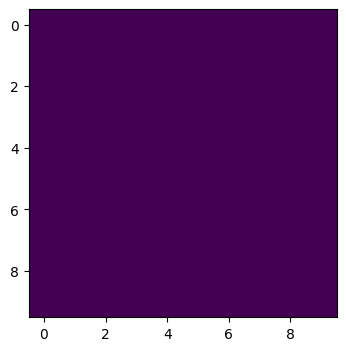

Evaluation 123 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 197.04it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.42it/s]


Completed. Saving
Time (s) to complete simulation 123: 0.8623929023742676


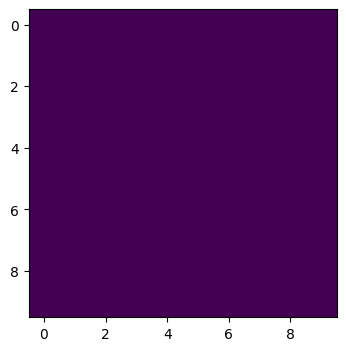

Evaluation 124 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 202.25it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.83it/s]


Completed. Saving
Time (s) to complete simulation 124: 0.8577795028686523


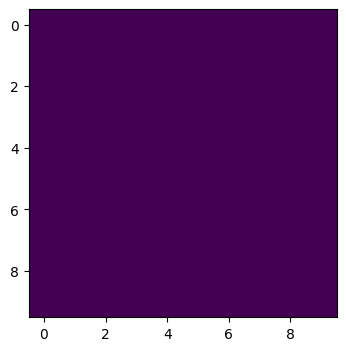

Evaluation 125 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.13it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.60it/s]


Completed. Saving
Time (s) to complete simulation 125: 0.8578085899353027


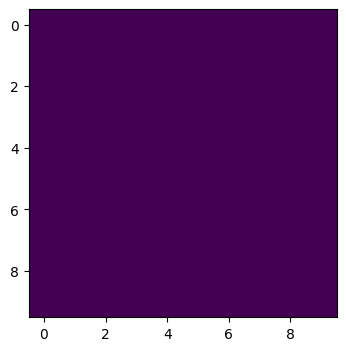

Evaluation 126 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.15it/s]


Completed. Saving
Time (s) to complete simulation 126: 0.8837294578552246


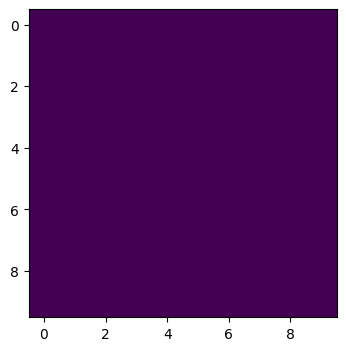

Evaluation 127 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.40it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.06it/s]


Completed. Saving
Time (s) to complete simulation 127: 1.142082929611206


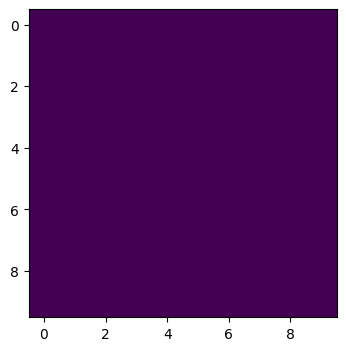

Evaluation 128 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 126.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.84it/s]


Completed. Saving
Time (s) to complete simulation 128: 1.4141709804534912


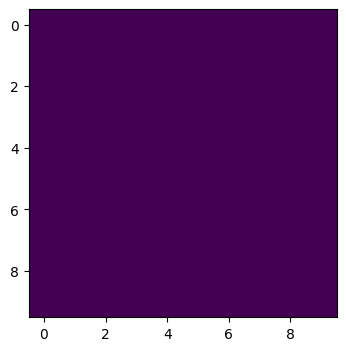

Evaluation 129 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 143.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 56.48it/s]


Completed. Saving
Time (s) to complete simulation 129: 1.2510275840759277


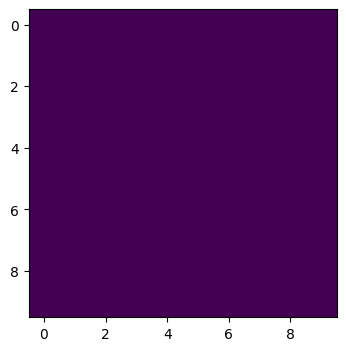

Evaluation 130 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.72it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.99it/s]


Completed. Saving
Time (s) to complete simulation 130: 0.8778057098388672


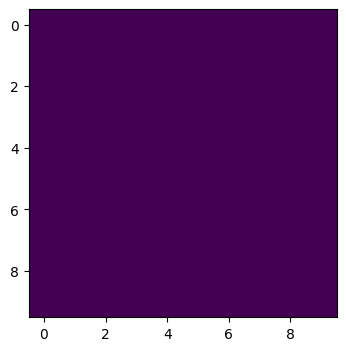

Evaluation 131 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.37it/s]


Completed. Saving
Time (s) to complete simulation 131: 0.8617172241210938


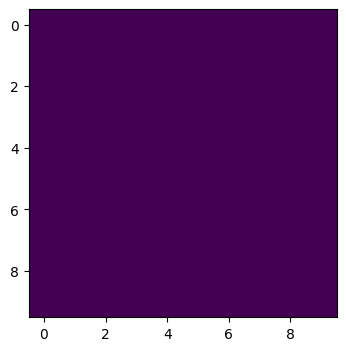

Evaluation 132 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.28it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.66it/s]


Completed. Saving
Time (s) to complete simulation 132: 0.8724441528320312


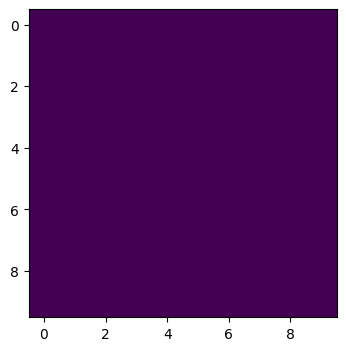

Evaluation 133 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.17it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.48it/s]


Completed. Saving
Time (s) to complete simulation 133: 0.8699507713317871


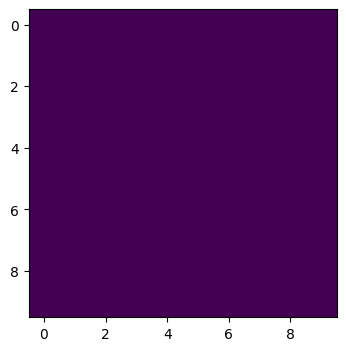

Evaluation 134 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 194.10it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.90it/s]


Completed. Saving
Time (s) to complete simulation 134: 0.8613607883453369


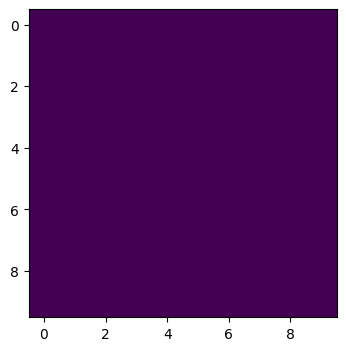

Evaluation 135 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 197.10it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.54it/s]


Completed. Saving
Time (s) to complete simulation 135: 0.863372802734375


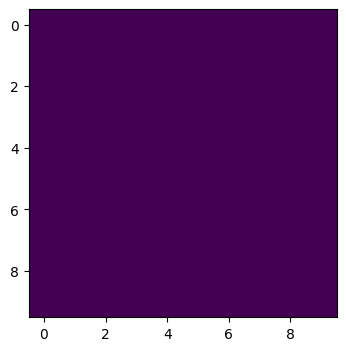

Evaluation 136 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.32it/s]


Completed. Saving
Time (s) to complete simulation 136: 0.8540217876434326


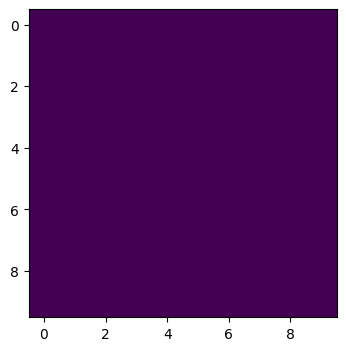

Evaluation 137 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 191.98it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.38it/s]


Completed. Saving
Time (s) to complete simulation 137: 0.8749637603759766


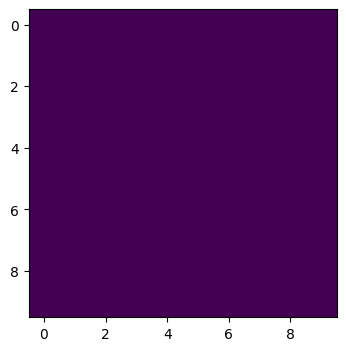

Evaluation 138 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.52it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.14it/s]


Completed. Saving
Time (s) to complete simulation 138: 0.8543634414672852


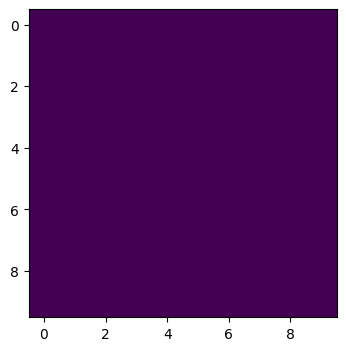

Evaluation 139 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 172.31it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.04it/s]


Completed. Saving
Time (s) to complete simulation 139: 1.3846824169158936


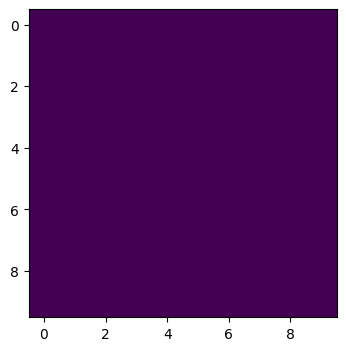

Evaluation 140 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 143.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.59it/s]


Completed. Saving
Time (s) to complete simulation 140: 1.3219513893127441


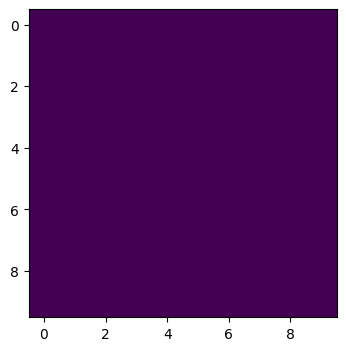

Evaluation 141 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 144.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 64.35it/s]


Completed. Saving
Time (s) to complete simulation 141: 1.1436939239501953


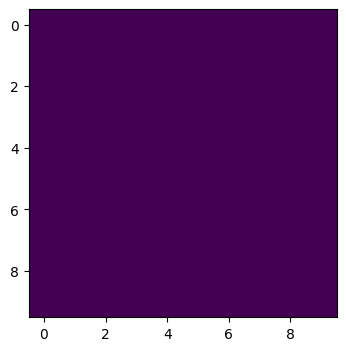

Evaluation 142 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.51it/s]


Completed. Saving
Time (s) to complete simulation 142: 0.8509676456451416


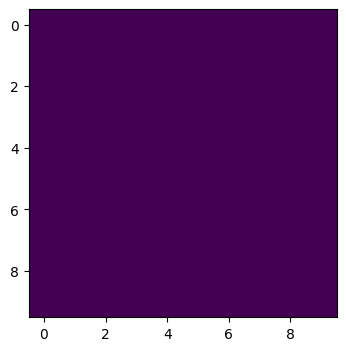

Evaluation 143 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.98it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.22it/s]


Completed. Saving
Time (s) to complete simulation 143: 0.8569657802581787


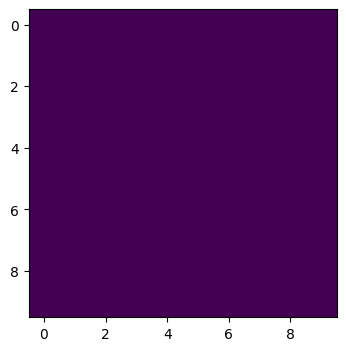

Evaluation 144 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.39it/s]


Completed. Saving
Time (s) to complete simulation 144: 0.8579621315002441


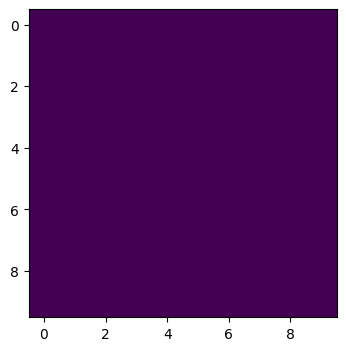

Evaluation 145 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 197.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.59it/s]


Completed. Saving
Time (s) to complete simulation 145: 0.8841276168823242


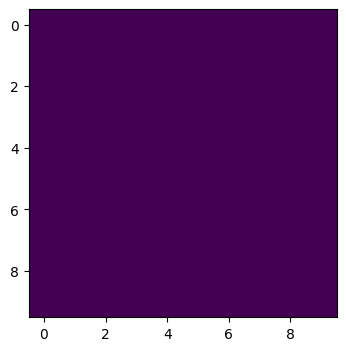

Evaluation 146 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.56it/s]


Completed. Saving
Time (s) to complete simulation 146: 0.8732380867004395


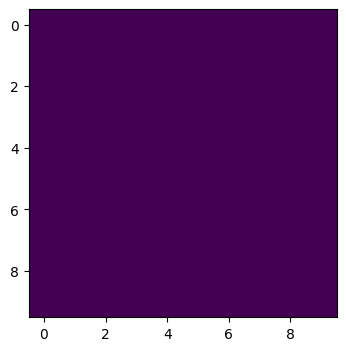

Evaluation 147 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 197.48it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.97it/s]


Completed. Saving
Time (s) to complete simulation 147: 0.8634884357452393


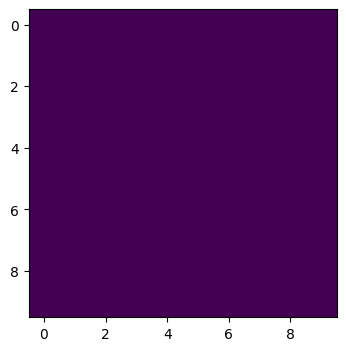

Evaluation 148 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.80it/s]


Completed. Saving
Time (s) to complete simulation 148: 0.8721203804016113


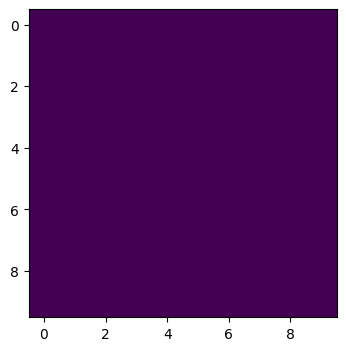

Evaluation 149 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.92it/s]


Completed. Saving
Time (s) to complete simulation 149: 0.8852040767669678


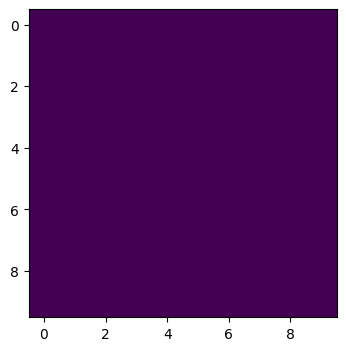

Evaluation 150 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.74it/s]


Completed. Saving
Time (s) to complete simulation 150: 0.8838591575622559


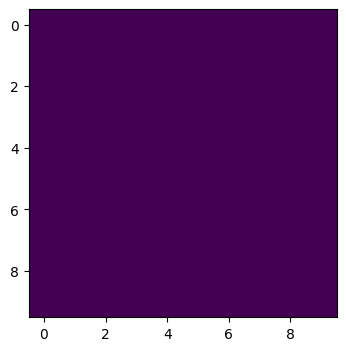

Evaluation 151 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 138.48it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.35it/s]


Completed. Saving
Time (s) to complete simulation 151: 1.3742830753326416


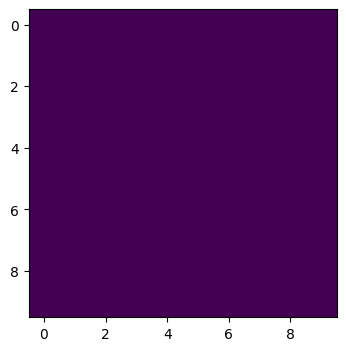

Evaluation 152 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 128.50it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.65it/s]


Completed. Saving
Time (s) to complete simulation 152: 1.3937652111053467


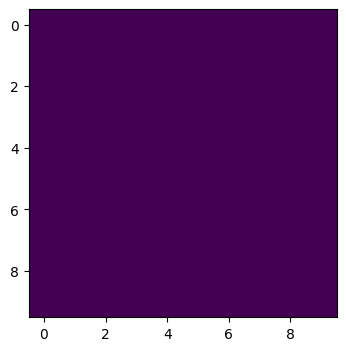

Evaluation 153 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 126.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 71.11it/s]


Completed. Saving
Time (s) to complete simulation 153: 1.1151282787322998


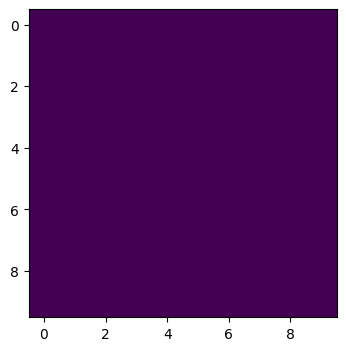

Evaluation 154 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.36it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.66it/s]


Completed. Saving
Time (s) to complete simulation 154: 0.8723256587982178


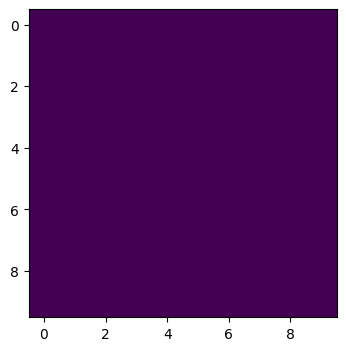

Evaluation 155 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.01it/s]


Completed. Saving
Time (s) to complete simulation 155: 0.8910551071166992


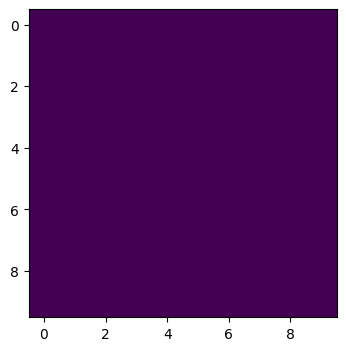

Evaluation 156 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 184.36it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.63it/s]


Completed. Saving
Time (s) to complete simulation 156: 0.899867057800293


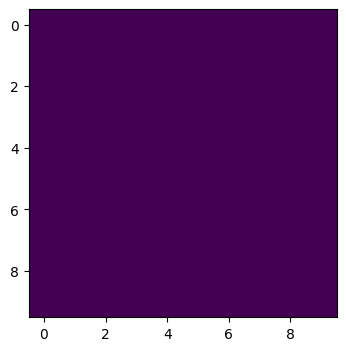

Evaluation 157 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.75it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.35it/s]


Completed. Saving
Time (s) to complete simulation 157: 0.892664909362793


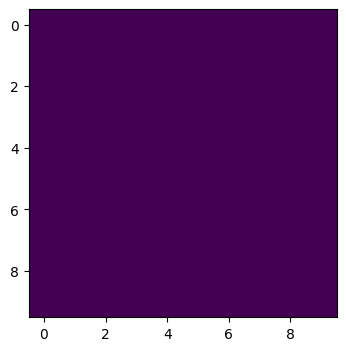

Evaluation 158 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 191.52it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.49it/s]


Completed. Saving
Time (s) to complete simulation 158: 0.8892192840576172


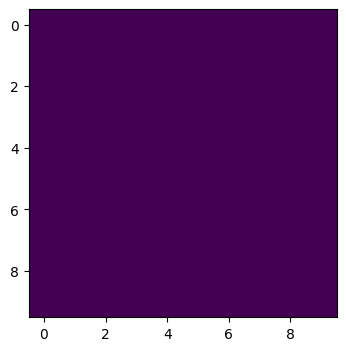

Evaluation 159 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.31it/s]


Completed. Saving
Time (s) to complete simulation 159: 0.8869810104370117


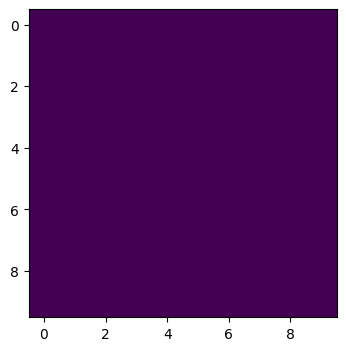

Evaluation 160 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 202.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.04it/s]


Completed. Saving
Time (s) to complete simulation 160: 0.8693325519561768


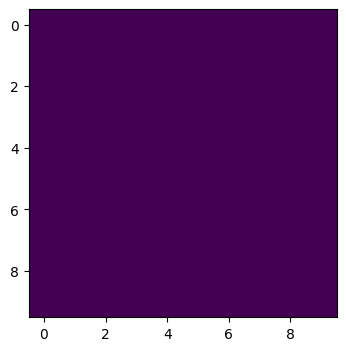

Evaluation 161 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.71it/s]


Completed. Saving
Time (s) to complete simulation 161: 0.9036939144134521


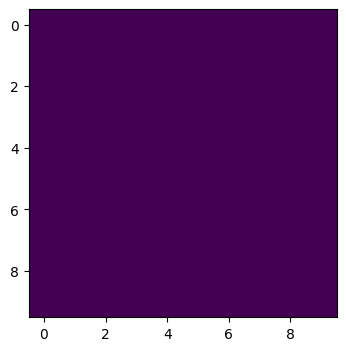

Evaluation 162 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 191.54it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.35it/s]


Completed. Saving
Time (s) to complete simulation 162: 1.151634931564331


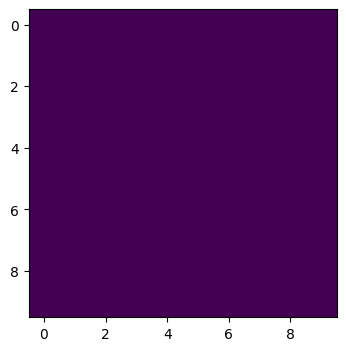

Evaluation 163 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 123.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 53.21it/s]


Completed. Saving
Time (s) to complete simulation 163: 1.3610947132110596


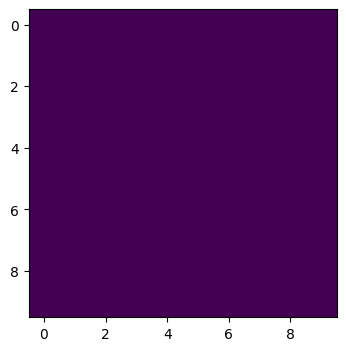

Evaluation 164 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 126.97it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 56.24it/s]


Completed. Saving
Time (s) to complete simulation 164: 1.3084533214569092


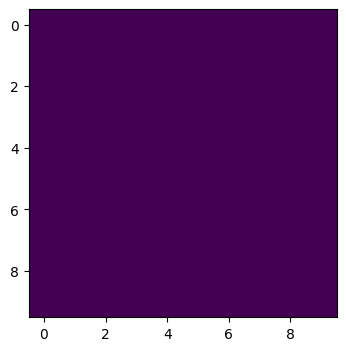

Evaluation 165 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.34it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 75.95it/s]


Completed. Saving
Time (s) to complete simulation 165: 0.9251108169555664


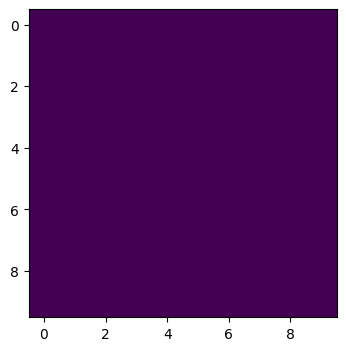

Evaluation 166 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.68it/s]


Completed. Saving
Time (s) to complete simulation 166: 0.8995320796966553


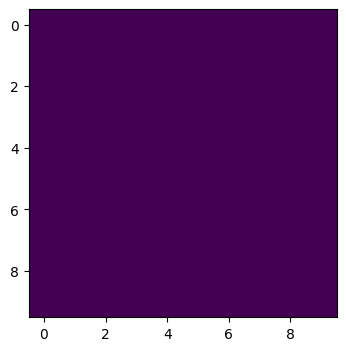

Evaluation 167 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 182.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.47it/s]


Completed. Saving
Time (s) to complete simulation 167: 0.9009077548980713


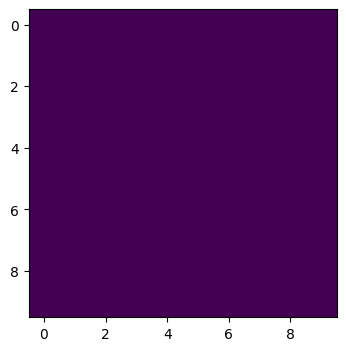

Evaluation 168 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 176.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.61it/s]


Completed. Saving
Time (s) to complete simulation 168: 0.9026129245758057


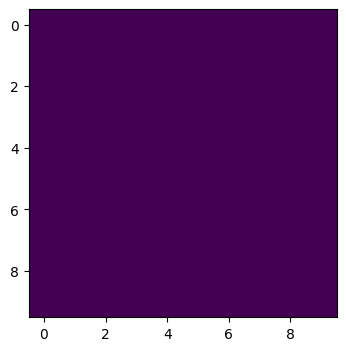

Evaluation 169 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.69it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.01it/s]


Completed. Saving
Time (s) to complete simulation 169: 0.8968980312347412


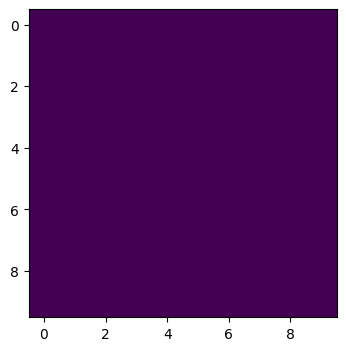

Evaluation 170 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.38it/s]


Completed. Saving
Time (s) to complete simulation 170: 0.8845019340515137


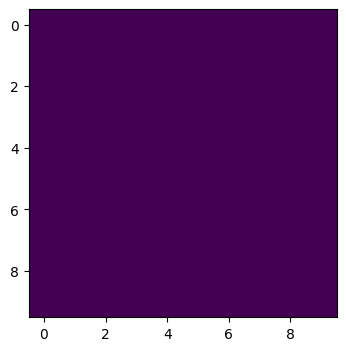

Evaluation 171 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.38it/s]


Completed. Saving
Time (s) to complete simulation 171: 0.8960394859313965


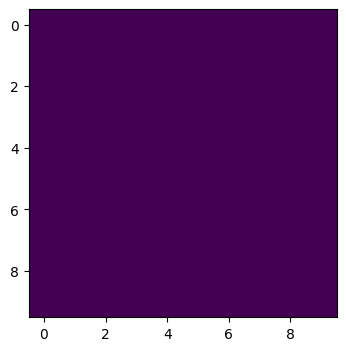

Evaluation 172 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 202.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.61it/s]


Completed. Saving
Time (s) to complete simulation 172: 0.884864330291748


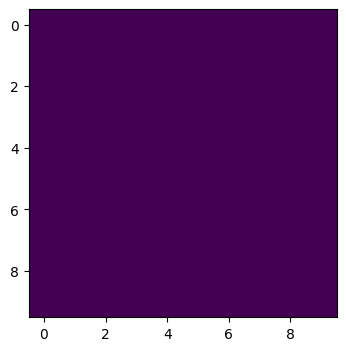

Evaluation 173 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 196.70it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.48it/s]


Completed. Saving
Time (s) to complete simulation 173: 0.8956120014190674


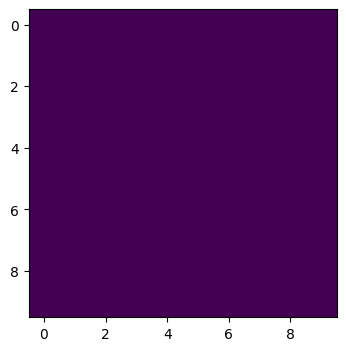

Evaluation 174 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 135.19it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.08it/s]


Completed. Saving
Time (s) to complete simulation 174: 1.388002634048462


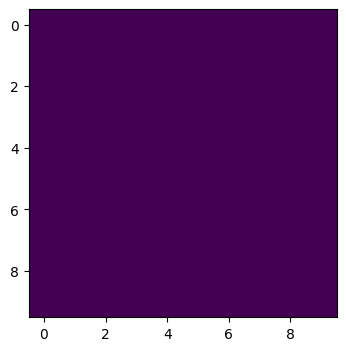

Evaluation 175 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 132.60it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.68it/s]


Completed. Saving
Time (s) to complete simulation 175: 1.3854868412017822


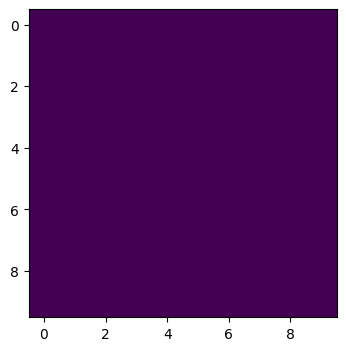

Evaluation 176 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 122.09it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.15it/s]


Completed. Saving
Time (s) to complete simulation 176: 1.0715208053588867


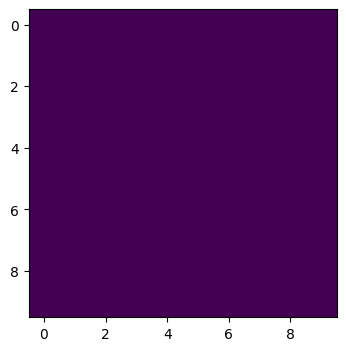

Evaluation 177 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.79it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.24it/s]


Completed. Saving
Time (s) to complete simulation 177: 0.9030165672302246


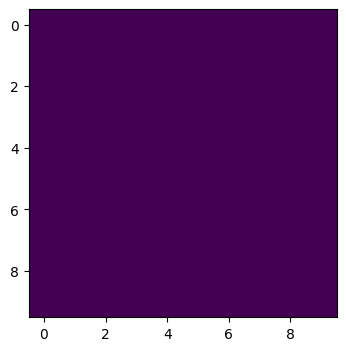

Evaluation 178 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.81it/s]


Completed. Saving
Time (s) to complete simulation 178: 0.9050567150115967


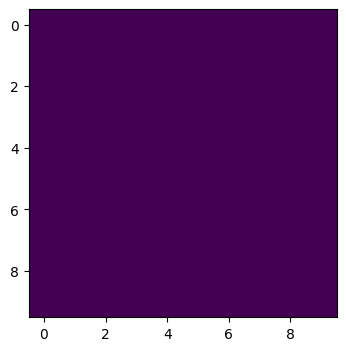

Evaluation 179 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 180.58it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.57it/s]


Completed. Saving
Time (s) to complete simulation 179: 0.9155254364013672


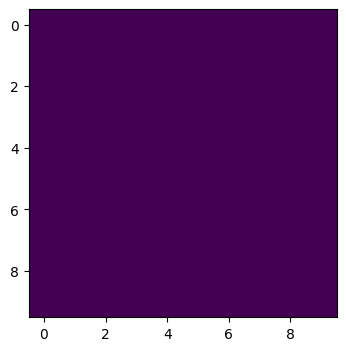

Evaluation 180 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 184.15it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.84it/s]


Completed. Saving
Time (s) to complete simulation 180: 0.9224011898040771


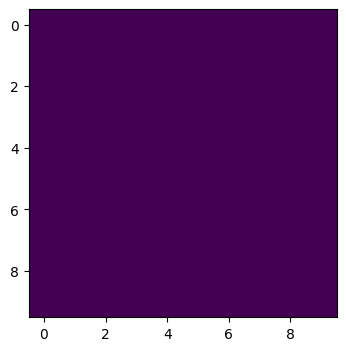

Evaluation 181 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 185.22it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.90it/s]


Completed. Saving
Time (s) to complete simulation 181: 0.9096240997314453


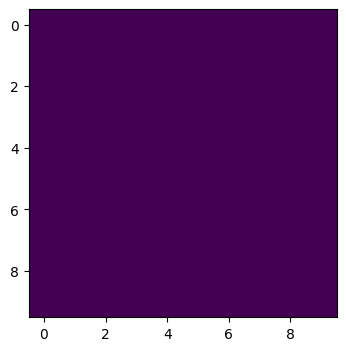

Evaluation 182 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 169.40it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.43it/s]


Completed. Saving
Time (s) to complete simulation 182: 0.9317722320556641


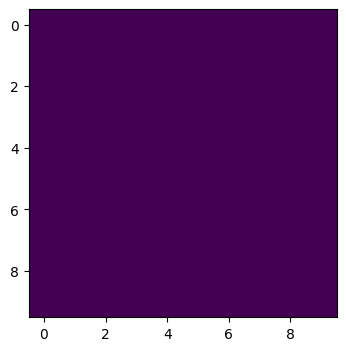

Evaluation 183 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.26it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.85it/s]


Completed. Saving
Time (s) to complete simulation 183: 0.893451452255249


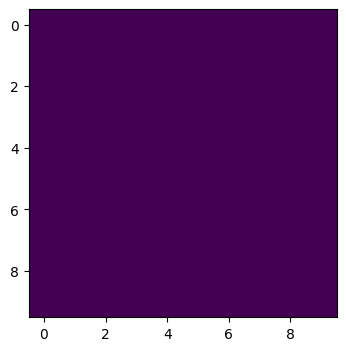

Evaluation 184 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 185.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.45it/s]


Completed. Saving
Time (s) to complete simulation 184: 0.902299165725708


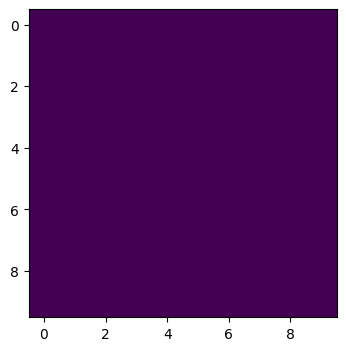

Evaluation 185 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.10it/s]


Completed. Saving
Time (s) to complete simulation 185: 1.2451708316802979


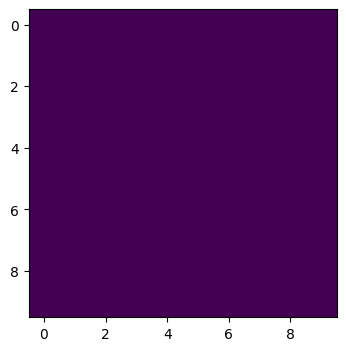

Evaluation 186 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 144.20it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.78it/s]


Completed. Saving
Time (s) to complete simulation 186: 1.3520615100860596


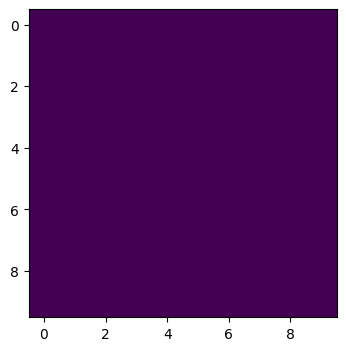

Evaluation 187 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 115.73it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 56.73it/s]


Completed. Saving
Time (s) to complete simulation 187: 1.3266417980194092


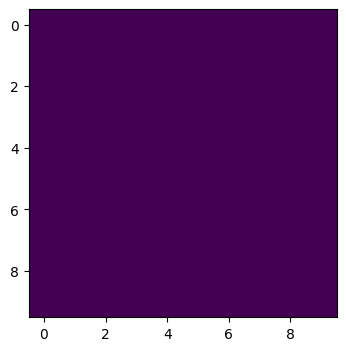

Evaluation 188 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.37it/s]


Completed. Saving
Time (s) to complete simulation 188: 0.9094593524932861


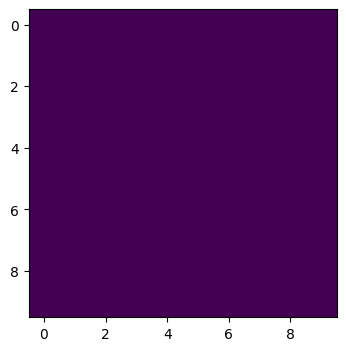

Evaluation 189 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.38it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.15it/s]


Completed. Saving
Time (s) to complete simulation 189: 0.9172933101654053


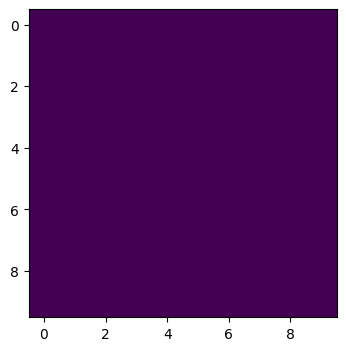

Evaluation 190 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.29it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.47it/s]


Completed. Saving
Time (s) to complete simulation 190: 0.9068126678466797


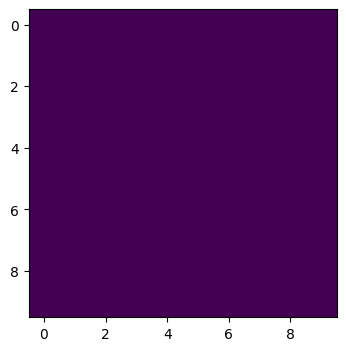

Evaluation 191 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 181.64it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.16it/s]


Completed. Saving
Time (s) to complete simulation 191: 0.9226412773132324


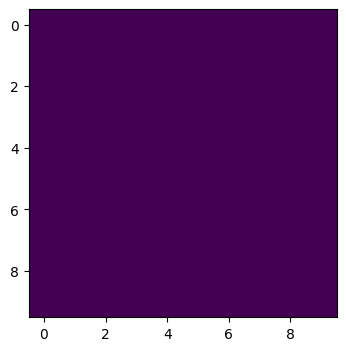

Evaluation 192 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 162.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.27it/s]


Completed. Saving
Time (s) to complete simulation 192: 0.9488084316253662


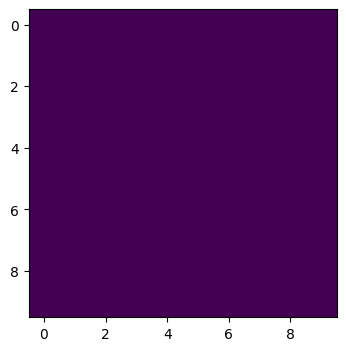

Evaluation 193 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 181.47it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.57it/s]


Completed. Saving
Time (s) to complete simulation 193: 0.9202468395233154


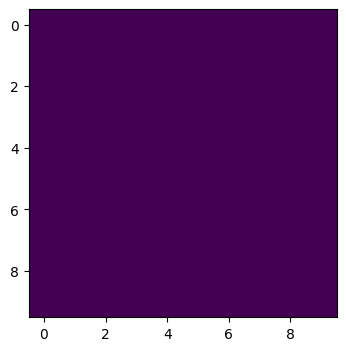

Evaluation 194 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.35it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.01it/s]


Completed. Saving
Time (s) to complete simulation 194: 0.8943459987640381


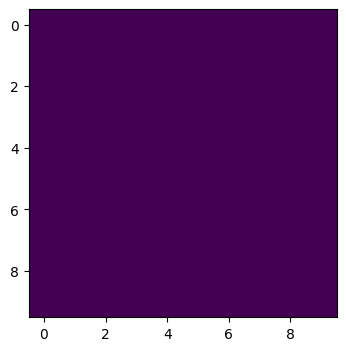

Evaluation 195 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.50it/s]


Completed. Saving
Time (s) to complete simulation 195: 0.8824856281280518


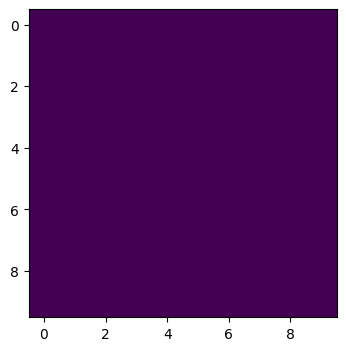

Evaluation 196 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.38it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 63.72it/s]


Completed. Saving
Time (s) to complete simulation 196: 1.0659327507019043


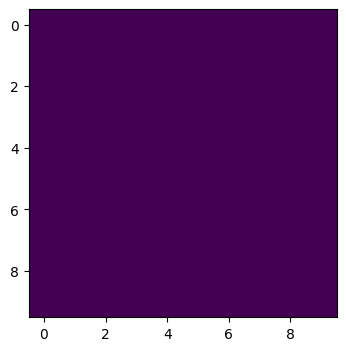

Evaluation 197 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 139.21it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.10it/s]


Completed. Saving
Time (s) to complete simulation 197: 1.414656162261963


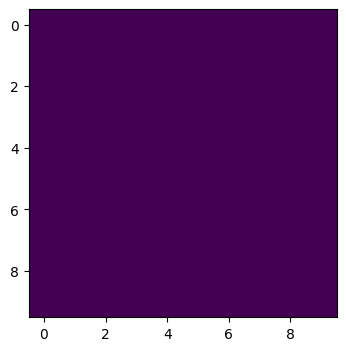

Evaluation 198 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 139.62it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.79it/s]


Completed. Saving
Time (s) to complete simulation 198: 1.4020111560821533


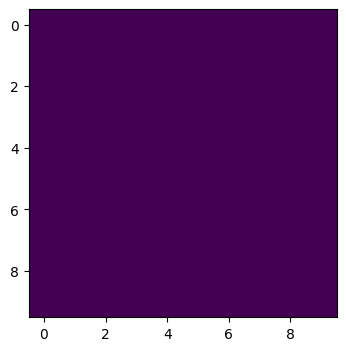

Evaluation 199 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.91it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 77.96it/s]


Completed. Saving
Time (s) to complete simulation 199: 0.9212346076965332


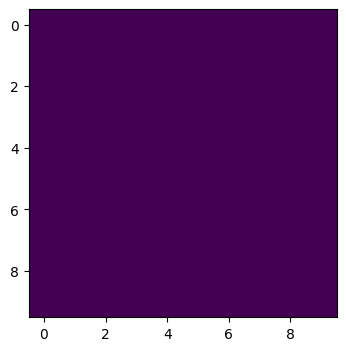

Evaluation 200 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 76.02it/s]


Completed. Saving
Time (s) to complete simulation 200: 0.9500536918640137


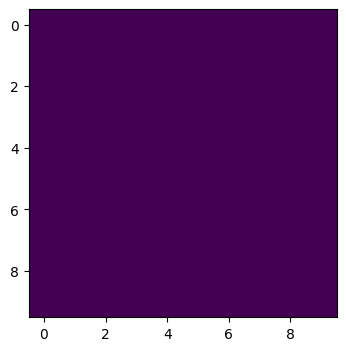

Evaluation 201 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.61it/s]


Completed. Saving
Time (s) to complete simulation 201: 0.8986542224884033


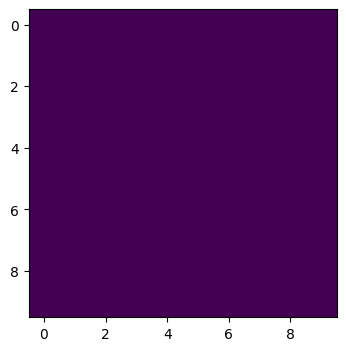

In [18]:
Jx = xs

results_dict = {}
approx_ys = np.zeros(xs.shape[0])
approx_ys1 = np.zeros(xs.shape[0])
approx_ys2 = np.zeros(xs.shape[0])

time_eval = np.zeros(xs.shape[0])

for i in range(0, Jx.shape[0]):
    J_mat = np.array([[0,0,0,0,0],
                      [0,0,Jx[i],0,0],
                      [0,Jx[i],0,Jx[i],0],
                      [0,0,Jx[i],0,0],
                      [0,0,0,0,0]])
    print("Evaluation " +str (i+1) +" of " +str(N_total))
    start_time = time.time()
    np.random.seed(0)
    sq_sim = IsingSim(N = 10, J_mat = J_mat, T = 2.7, save_trajectories=True, eqSteps = 50, mcSteps = 50)  # Intializing the object
    sq_sim.performIsingSim()   # Running the sim
    end_time = time.time()
    time_eval[i]= end_time-start_time
    print("Time (s) to complete simulation " +str(i+1)+ ": " +str(time_eval[i]))
    results_dict[i] = {'sim': sq_sim.results,}

    approx_ys[i] = results_dict[i]['sim']['SpecificHeat']
    approx_ys1[i] = results_dict[i]['sim']['Magnetization']
    approx_ys2[i] = results_dict[i]['sim']['Susceptibility']

    plt.imshow(results_dict[i]['sim']['config'][-1])
    plt.show()

(0.9380061329893805, 0.19506110781307534)

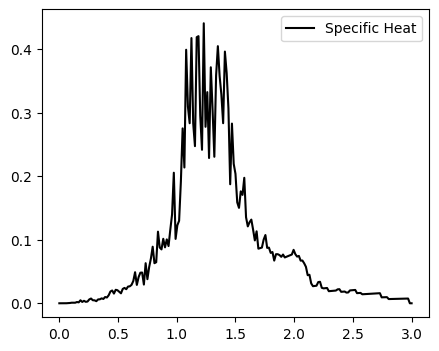

In [19]:
plt.plot(xs, approx_ys, "k", label="Specific Heat")
plt.legend(loc="best")
np.mean(time_eval), np.std(time_eval)

# Symbolic Regression


Here, we explore the symbolic regression over the Ising model predictions.

## Specific Heat

In [20]:
inputs2 = xs.reshape(-1, 1)
outputs2 = approx_ys

In [21]:
# Import the package
from pysr import PySRRegressor

# Instantiate the regressor
model = PySRRegressor(  niterations=100, population_size=150,
                        binary_operators=["*", "-", "+", "/"], unary_operators=["square", "exp", "log", "tanh"],
                        loss="f(x, y) = (x - y)^2", # Use a custom loss function
                        complexity_of_operators = {"square": 1, "exp": 1}, # Set the complexity of the operators
                        complexity_of_constants=0.5, # Set the complexity of the constants
                        complexity_of_variables=1, # Set the complexity of the variables
                        maxsize=12, # Allow greater complexity
                        maxdepth=6) # Avoid deep nesting

In [22]:
model.fit(inputs2, outputs2)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1281: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:240: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                                 x0   
	1         5.457295e+00                                square(-0.29375926)   
	2         2.521639e-07                      (0.5555533 * tanh(0.1566212))   
	3         9.534018e-02                    (0.11189756 * tanh(square(x0)))   
	4         3.744631e-01                               square(x0 / exp(x0))   
	5         9.624529e-02                   square(x0 / exp(x0 * 0.9157717))   
	6         3.613789e-01               (square(tanh(square(x0))) / exp(x0))   
	7         5.254257e-01     (square(square(x0)) / exp(exp(x0) - 1.343546))   
	8         1.059985e-01           (square(square(x0)) / exp(exp(x0) - x0))   
	9         2.705007e-01  (square(tanh(square(x0)) * x0) / exp(square(x0)))   
	10  >>>>  4.096565e-01  (tanh(square(square(x0 + -0.23297687))) / exp(...   
	
	        loss  complexity  
	0   2.789404           1  
	1   0.011897           2  
	2   0.011897           3  
	3   0.010815           4  
	4   0.007437           5  
	5   0.006755           6  
	6   0.004706           7  
	7   0.002783           8  
	8   0.002503           9  
	9   0.001910          10  
	10  0.001268          11  
]

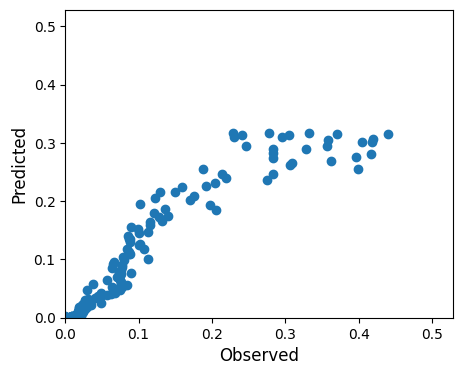

In [23]:
plt.figure()
plt.scatter(outputs2, model.predict(inputs2), label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.xlim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.ylim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.show()

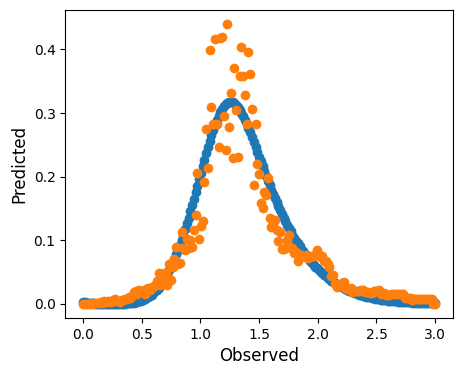

In [24]:
plt.figure()
plt.scatter(inputs2, model.predict(inputs2), label='Training data')
plt.scatter(inputs2,outputs2, label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.show()

In [25]:
from sklearn.metrics import r2_score
r2 = r2_score(outputs2, model.predict(inputs2))
print(f'Best identified model (LaTeX): {model.latex()}')
print(f'R2 score: {r2}')

Best identified model (LaTeX): e^{- \left(x_{0} - 0.295\right)^{2}} \tanh{\left(\left(x_{0} - 0.233\right)^{4} \right)}
R2 score: 0.8934359121827176


## Magnetization

In [26]:
inputs2 = xs.reshape(-1, 1)
outputs2 = approx_ys1

In [27]:
# Import the package
from pysr import PySRRegressor

# Instantiate the regressor
model = PySRRegressor(  niterations=100, population_size=150,
                        binary_operators=["*", "-", "+", "/"], unary_operators=["square", "exp", "log", "tanh"],
                        loss="f(x, y) = (x - y)^2", # Use a custom loss function
                        complexity_of_operators = {"square": 1, "exp": 1}, # Set the complexity of the operators
                        complexity_of_constants=0.5, # Set the complexity of the constants
                        complexity_of_variables=1, # Set the complexity of the variables
                        maxsize=12, # Allow greater complexity
                        maxdepth=6) # Avoid deep nesting

In [28]:
model.fit(inputs2, outputs2)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1281: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:240: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                 x0   
	1        3.440174                                  (x0 * 0.43090135)   
	2        0.567094                                   square(tanh(x0))   
	3        0.860769                     tanh(square(x0 + -0.33272856))   
	4        0.126717         tanh(0.08006616 + square(-0.3838568 + x0))   
	5        0.157566  tanh(square(0.31498846 + square(-0.44299716 + ...   
	6  >>>>  0.222786  (square(tanh(square(x0 - 0.1343021))) - (-0.01...   
	7        0.027869  (tanh(square(x0) - square(tanh(x0))) - (-0.012...   
	
	       loss  complexity  
	0  1.006309           1  
	1  0.032261           2  
	2  0.018298           3  
	3  0.007737           4  
	4  0.006005           6  
	5  0.005130           7  
	6  0.002629          10  
	7  0.002487          12  
]

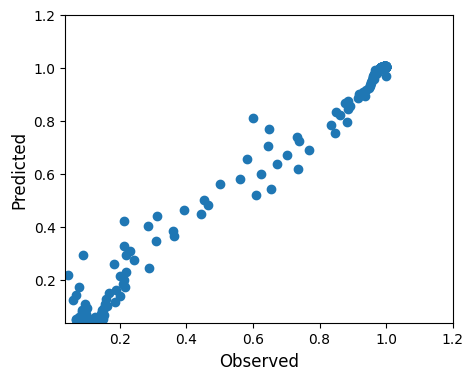

In [29]:
plt.figure()
plt.scatter(outputs2, model.predict(inputs2), label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.xlim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.ylim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.show()

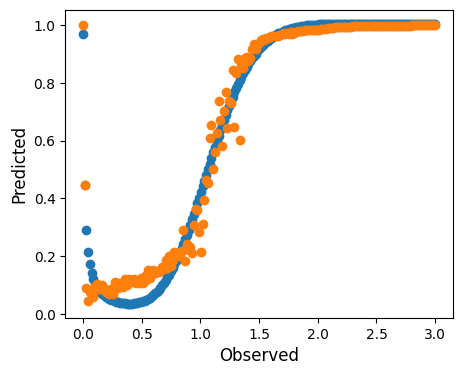

In [30]:
plt.figure()
plt.scatter(inputs2, model.predict(inputs2), label='Training data')
plt.scatter(inputs2,outputs2, label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.show()

In [31]:
from sklearn.metrics import r2_score
r2 = r2_score(outputs2, model.predict(inputs2))
print(f'Best identified model (LaTeX): {model.latex()}')
print(f'R2 score: {r2}')

Best identified model (LaTeX): \tanh^{2}{\left(\left(x_{0} - 0.134\right)^{2} \right)} + \frac{0.0125}{x_{0} + 0.0129}
R2 score: 0.9822071080437778


## Susceptibility

In [32]:
inputs2 = xs.reshape(-1, 1)
outputs2 = approx_ys2

In [33]:
# Import the package
from pysr import PySRRegressor

# Instantiate the regressor
model = PySRRegressor(  niterations=100, population_size=150,
                        binary_operators=["*", "-", "+", "/"], unary_operators=["square", "exp", "log", "tanh"],
                        loss="f(x, y) = (x - y)^2", # Use a custom loss function
                        complexity_of_operators = {"square": 1, "exp": 1}, # Set the complexity of the operators
                        complexity_of_constants=0.5, # Set the complexity of the constants
                        complexity_of_variables=1, # Set the complexity of the variables
                        maxsize=12, # Allow greater complexity
                        maxdepth=6) # Avoid deep nesting

In [34]:
model.fit(inputs2, outputs2)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1281: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:240: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                 x0   
	1        1.873145                                     exp(-0.953112)   
	2        0.070012                         exp(exp(x0) * -0.19743572)   
	3        0.255881           exp(square(1.1123776 - x0) * -1.8396099)   
	4  >>>>  0.182964  exp(square(-1.2618132 + square(x0)) * -1.0145565)   
	5        0.021529  (square(x0) / exp(square(square(x0) - 0.843459...   
	6        0.093071  (exp(1.8219838 - square(x0)) * tanh(square(squ...   
	7        0.038376  (exp((1.8219838 - square(x0)) * x0) * tanh(squ...   
	
	       loss  complexity  
	0  2.807503           1  
	1  0.431344           2  
	2  0.374983           4  
	3  0.224779           6  
	4  0.187196           7  
	5  0.183209           8  
	6  0.152092          10  
	7  0.140855          12  
]

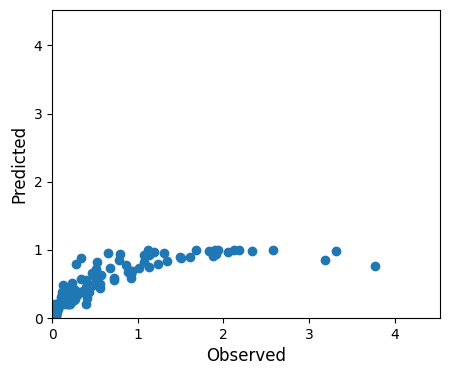

In [35]:
plt.figure()
plt.scatter(outputs2, model.predict(inputs2), label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.xlim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.ylim([np.min(outputs2)*0.8, np.max(outputs2)*1.2])
plt.show()

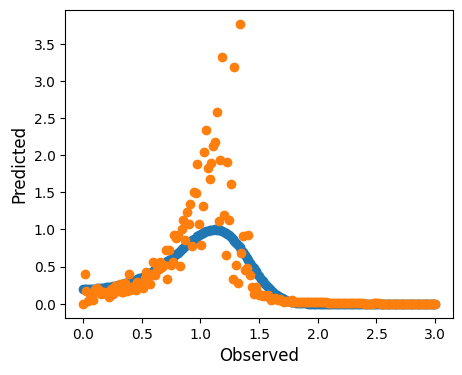

In [36]:
plt.figure()
plt.scatter(inputs2, model.predict(inputs2), label='Training data')
plt.scatter(inputs2,outputs2, label='Training data')
plt.xlabel('Observed', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.show()

In [37]:
from sklearn.metrics import r2_score
r2 = r2_score(outputs2, model.predict(inputs2))
print(f'Best identified model (LaTeX): {model.latex()}')
print(f'R2 score: {r2}')

Best identified model (LaTeX): e^{- 1.62 \left(0.792 x_{0}^{2} - 1\right)^{2}}
R2 score: 0.566017292119741


In [38]:
model.equations_

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,2.807503,0.000000,x0,x0,PySRFunction(X=>x0)
1,2,0.431344,1.873145,exp(-0.953112),0.385539356153631,PySRFunction(X=>0.385539356153631)
2,4,0.374983,0.070012,exp(exp(x0) * -0.19743572),exp(-0.19743572*exp(x0)),PySRFunction(X=>exp(-0.19743572*exp(x0)))
3,6,0.224779,0.255881,exp(square(1.1123776 - x0) * -1.8396099),exp(-2.2763037184973*(1 - 0.898975311980392*x0...,PySRFunction(X=>exp(-2.2763037184973*(1 - 0.89...
4,7,0.187196,0.182964,exp(square(-1.2618132 + square(x0)) * -1.0145565),exp(-1.61534901144298*(0.792510333542239*x0**2...,PySRFunction(X=>exp(-1.61534901144298*(0.79251...
5,8,0.183209,0.021529,(square(x0) / exp(square(square(x0) - 0.843459...,x0**2*exp(-(x0**2 - 0.8434599)**2),PySRFunction(X=>x0**2*exp(-(x0**2 - 0.8434599)...
6,10,0.152092,0.093071,(exp(1.8219838 - square(x0)) * tanh(square(squ...,6.18411433526976*exp(-x0**2)*tanh(x0**8),PySRFunction(X=>6.18411433526976*exp(-x0**2)*t...
7,12,0.140855,0.038376,(exp((1.8219838 - square(x0)) * x0) * tanh(squ...,exp(x0*(1.8219838 - x0**2))*tanh(x0**8),PySRFunction(X=>exp(x0*(1.8219838 - x0**2))*ta...


In [39]:
model.equations_['equation'][6]

'(exp(1.8219838 - square(x0)) * tanh(square(square(square(x0)))))'